In [1]:
#Importing necessary packages
import pandas as pd
import numpy as np
import scipy as sp
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm

from matplotlib.patches import Patch
from matplotlib.ticker import FuncFormatter
from scipy.stats import shapiro, kstest, levene, ttest_1samp
from scipy.stats import gaussian_kde
from matplotlib import gridspec
from scipy import stats
from statsmodels.formula.api import ols

In [2]:
import matplotlib.pyplot as plt
plt.rcParams['text.usetex'] = False

In [3]:
#Important Data
df = pd.read_csv ('Landforms.csv')
LWData = pd.read_csv ('DeltaLW.csv')
LWDataFan = pd.read_csv ('FluvialFanLW.csv')
AData = pd.read_csv ('DeltaAngles.csv')
ADataFan = pd.read_csv ('FluvialFanAngles.csv')

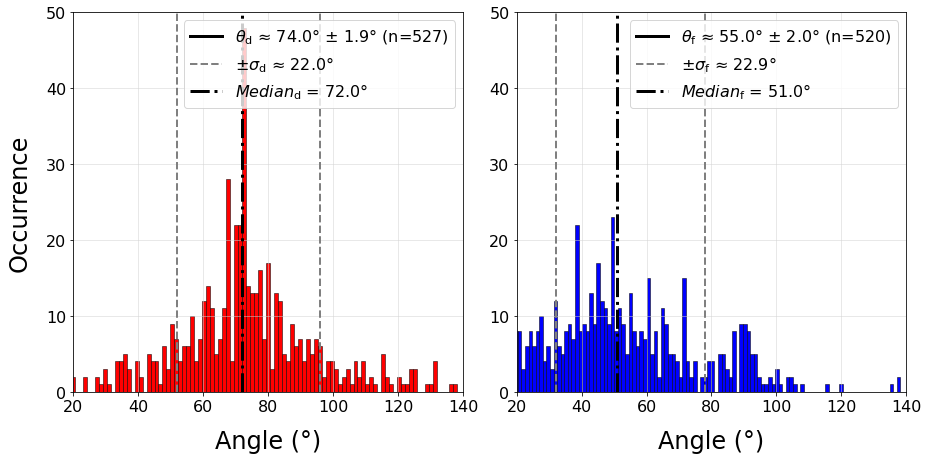

In [4]:
# Figures 5a & 5b 

def plot_histogram_and_statistics(data, subplot_loc, xlim=(20, 140), ylim=(0, 50)):
    ax = plt.subplot(1, 2, subplot_loc)
    ax.set_facecolor('white')
    ax.grid(color='lightgrey', linestyle='-', linewidth=0.5)

    # Plot histogram
    ax.hist(data, bins=120, color='Red' if subplot_loc == 1 else 'Blue', edgecolor='black', linewidth=0.5)

    # Labels
    ax.set_xlabel('Angle (°)', fontsize=24, labelpad=15)
    if subplot_loc == 1:
        ax.set_ylabel('Occurrence', fontsize=24, labelpad=15)

    ax.set_xlim(xlim)
    ax.set_ylim(ylim)

    # Statistics
    mean_value = data.mean()
    std_value = data.std()
    median_value = data.median()
    n_value = len(data)
    ci_margin = 1.96 * (std_value / np.sqrt(n_value))

    # Choose correct subscript
    suffix = 'd' if subplot_loc == 1 else 'f'

    # Labels
    mean_label = fr'$\theta_{{\mathrm{{{suffix}}}}}$ ≈ {mean_value:.1f}° ± {ci_margin:.1f}° (n={n_value})'
    std_label = fr'$\pm \sigma_{{\mathrm{{{suffix}}}}}$ ≈ {std_value:.1f}°'
    median_label = fr'$Median_{{\mathrm{{{suffix}}}}}$ = {median_value:.1f}°'

    # Store handles in desired order
    mean_handle, = ax.plot([], [], color='black', linestyle='-', linewidth=3, label=mean_label)  # dummy
    std_handle = ax.axvline(mean_value + std_value, color='gray', linestyle='--', linewidth=2, label=std_label)
    ax.axvline(mean_value - std_value, color='gray', linestyle='--', linewidth=2)
    median_handle = ax.axvline(median_value, color='black', linestyle='-.', linewidth=3, label=median_label)

    # Apply legend in desired order
    ax.legend(handles=[mean_handle, std_handle, median_handle], fontsize=16)
    ax.tick_params(axis='both', labelsize=16)

# Create the figure and plot both histograms
plt.figure(figsize=(13, 6.5))
plot_histogram_and_statistics(AData.Angle, 1)
plot_histogram_and_statistics(ADataFan.Angle, 2)
plt.tight_layout()
plt.show()


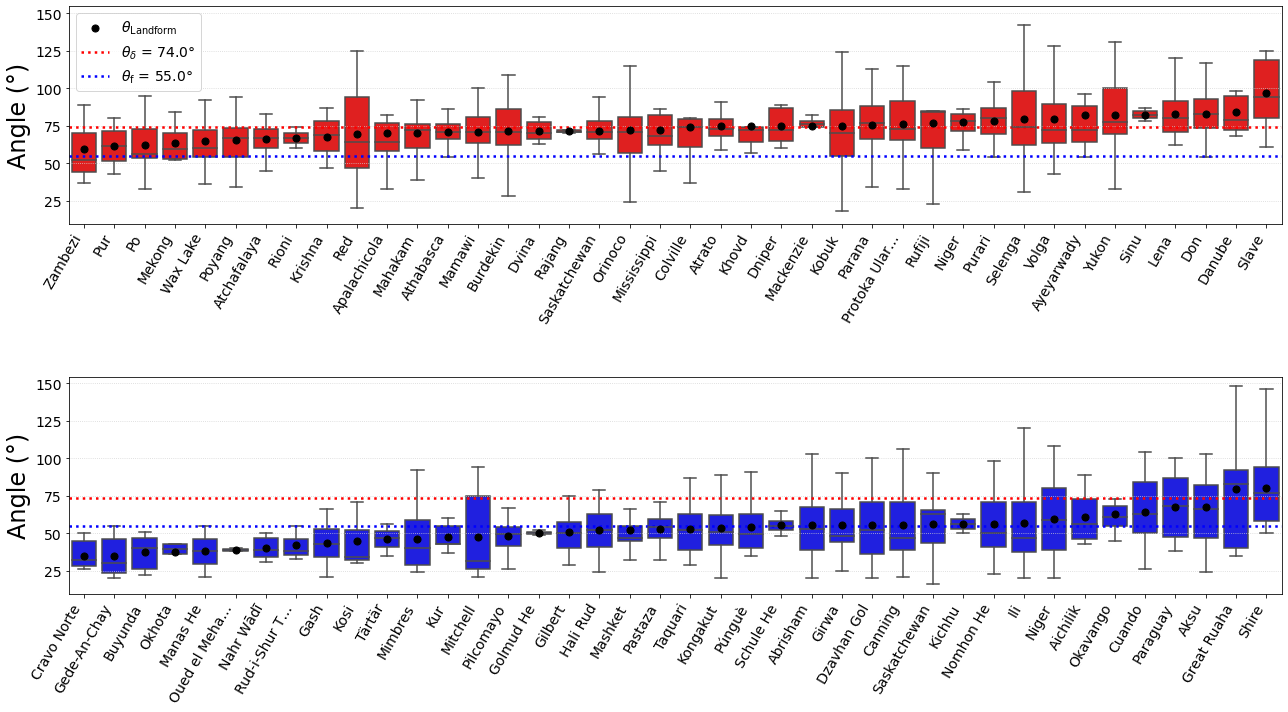

In [5]:
#Figures 5c and 5d

# Add 'Group' column
ADataFan['Group'] = 'Fluvial Fan'
AData['Group'] = 'Delta'
combined = pd.concat([AData[['Name', 'Angle', 'Group']], ADataFan[['Name', 'Angle', 'Group']]])

# Count samples per Name
name_counts = combined['Name'].value_counts()

# Calculate group means
avg_delta_angle = AData['Angle'].mean()
avg_fan_angle = ADataFan['Angle'].mean()

# Sort names by mean angle (ascending)
delta_mean_order = (
    combined[combined['Group'] == 'Delta']
    .groupby('Name')['Angle']
    .mean()
    .sort_values(ascending=True)
    .index.tolist()
)

fan_mean_order = (
    combined[combined['Group'] == 'Fluvial Fan']
    .groupby('Name')['Angle']
    .mean()
    .sort_values(ascending=True)
    .index.tolist()
)

# Truncate long names if needed
delta_mean_order = [name[:12] + '…' if len(name) > 12 else name for name in delta_mean_order]
fan_mean_order = [name[:12] + '…' if len(name) > 12 else name for name in fan_mean_order]
combined['Name'] = combined['Name'].apply(lambda name: name[:12] + '…' if len(name) > 12 else name)

# Create figure with increased width for better label spacing
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(18, 10), sharey=True)

# Prepare delta data
delta_data = combined[combined['Group'] == 'Delta'].copy()
delta_data['Name'] = pd.Categorical(delta_data['Name'], categories=delta_mean_order, ordered=True)
combined['Name'] = combined['Name'].apply(lambda name: name[:12] + '…' if len(name) > 12 else name)

# Delta boxplot
sns.boxplot(data=delta_data, x='Name', y='Angle', color='red', showfliers=False, ax=ax1)

# Plot per-landform theta
delta_means = delta_data.groupby('Name')['Angle'].mean()
ax1.scatter(
    range(len(delta_mean_order)),
    delta_means[delta_mean_order],
    color='black',
    zorder=5,
    label=rf'$\theta_{{\mathrm{{Landform}}}}$',
    s=50
)
ax1.axhline(avg_delta_angle, color='red', linestyle=':', linewidth=2.5, 
            label=rf'$\theta_{{\delta}}$ = {avg_delta_angle:.1f}°')
ax1.axhline(avg_fan_angle, color='blue', linestyle=':', linewidth=2.5, 
            label=rf'$\theta_{{\mathrm{{f}}}}$ = {avg_fan_angle:.1f}°')
ax1.set_title('', fontsize=32)
ax1.set_ylabel('Angle (°)', fontsize=24)
ax1.set_xticklabels(
    delta_mean_order,
    rotation=60, ha='right', fontsize=14
)

ax1.legend(fontsize=14, loc='upper left')
ax1.grid(axis='y', linestyle=':', color='lightgrey')
ax1.set_xlabel('')
ax1.tick_params(axis='y', labelsize=14) 

# Prepare fan data
fan_data = combined[combined['Group'] == 'Fluvial Fan'].copy()
fan_data['Name'] = pd.Categorical(fan_data['Name'], categories=fan_mean_order, ordered=True)

# Fluvial Fan boxplot
sns.boxplot(data=fan_data, x='Name', y='Angle', color='blue', showfliers=False, ax=ax2)
# Plot per-landform mean
fan_means = fan_data.groupby('Name')['Angle'].mean()
ax2.scatter(range(len(fan_mean_order)), fan_means[fan_mean_order], color='black', zorder=5, s=50)

ax2.axhline(avg_delta_angle, color='red', linestyle=':', linewidth=2.5)
ax2.axhline(avg_fan_angle, color='blue', linestyle=':', linewidth=2.5)
ax2.set_title('', fontsize=32)
ax2.set_ylabel('Angle (°)', fontsize=24)
ax2.set_xticklabels(
    fan_mean_order,
    rotation=60, ha='right', fontsize=14
)
ax2.grid(axis='y', linestyle=':', color='lightgrey')
ax2.set_xlabel('')
ax2.tick_params(axis='y', labelsize=14) 

plt.tight_layout()
plt.subplots_adjust(hspace=0.7)
plt.show()


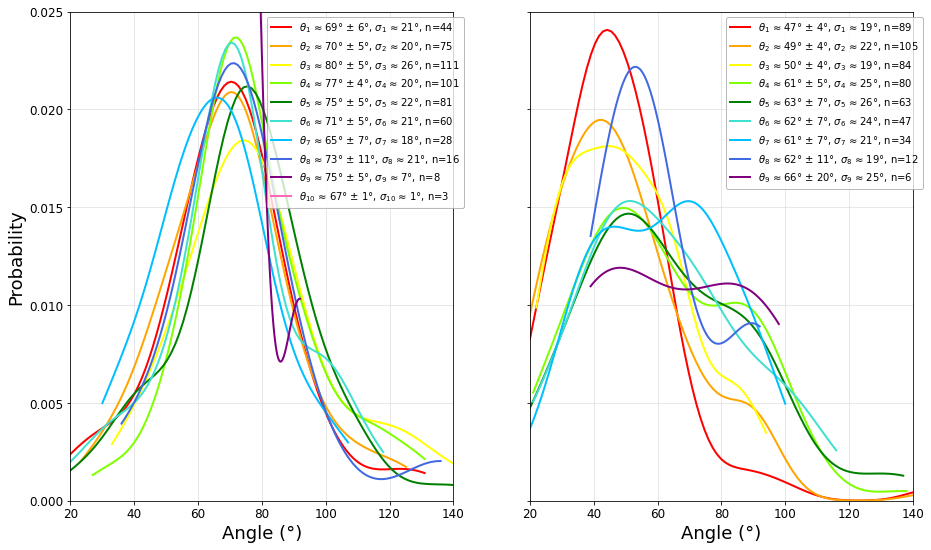

In [6]:
#Figures 6a and 6b

def plot_histogram(ax, grouped_data, title, x_label, x_limit, y_limit):
    colors = {'1': 'red', '2': 'orange', '3': 'yellow', '4': 'chartreuse', '5': 'green', '6': 'turquoise',
              '7': 'deepskyblue', '8': 'royalblue', '9': 'purple', '10': 'hotpink'}

    for group_name, group_data in grouped_data:
        if len(group_data) < 2:
            continue

        # Plot the density curve only
        density = gaussian_kde(group_data)
        x_vals = np.linspace(group_data.min(), group_data.max(), 100)

        # Calculate statistics
        mean_val = group_data.mean()
        std_val = group_data.std()
        n_val = len(group_data)
        ci_margin = 1.96 * (std_val / np.sqrt(n_val))

        # Plot line and label with confidence interval
        ax.plot(
            x_vals,
            density(x_vals),
            color=colors[str(group_name)],
            label=(
                f"$\\theta_{{{title}{group_name}}}$ ≈ {mean_val:.0f}° ± {ci_margin:.0f}°, "
                f"$\\sigma_{{{title}{group_name}}}$ ≈ {std_val:.0f}°, "
                f"n={n_val}"
            ),
            linewidth=2
        )

    # Titles and labels
    ax.set_title(title, loc="left", fontsize=24)
    ax.set_ylabel('Probability', fontsize=18)
    ax.set_xlabel(x_label, fontsize=18)
    ax.set_xlim(x_limit)
    if y_limit:
        ax.set_ylim(y_limit)
    ax.tick_params(axis='both', labelsize=12)

    # Set background and grid
    ax.set_facecolor('white')
    ax.grid(color='lightgrey', linestyle='-', linewidth=0.5)

    # Add legend with smaller font
    legend = ax.legend(fontsize=10, bbox_to_anchor=(0.5, 1), loc='upper left')

    # Style legend box
    legend.get_frame().set_facecolor('white')
    legend.get_frame().set_edgecolor('darkgrey')


# Create subplots
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(13, 9), sharey=True, sharex=True)

# Plot histogram for delta data
plot_histogram(axs[0], AData.groupby('Order')['Angle'], '', 'Angle (°)', (20, 140), (0, 0.025))

# Plot histogram for fluvial fan data
plot_histogram(axs[1], ADataFan.groupby('Order')['Angle'], '', 'Angle (°)', (20, 140), (0, 0.025))

# Remove y-axis label from the right plot
axs[1].set_ylabel('')

# Adjust layout
plt.subplots_adjust(left=0.05, right=0.95, hspace=0.5)

# Show the plot
plt.show()


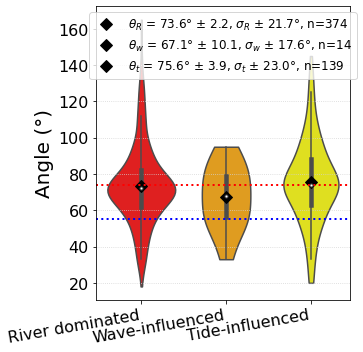

In [7]:
# Compute the type counts
type_counts = AData['Type'].value_counts()

type_colors = {
    'River dominated': 'red',
    'Tide-influenced': 'yellow',
    'Wave-influenced': 'orange'
}
# Delta Types Plot
fig1, ax1 = plt.subplots(figsize=(5, 5))
sns.violinplot(data=AData, x='Type', y='Angle', palette=type_colors, cut=0, inner='box', ax=ax1)

# Track legend handles and labels
handles = []
labels = []

# Add mean diamond markers and legend entries
for i, group in enumerate(AData['Type'].unique()):
    group_data = AData[AData['Type'] == group]['Angle']
    mean_val = group_data.mean()
    std_val = group_data.std()
    n = len(group_data)
    
    # 95% CI
    ci = stats.t.interval(0.95, df=n-1, loc=mean_val, scale=std_val/np.sqrt(n))
    ci_half_width = (ci[1] - ci[0]) / 2
    
    # Abbreviations
    abbr = {'River dominated': 'R', 'Wave-influenced': 'w', 'Tide-influenced': 't'}.get(group, group)
    
    # Plot the diamond
    handle = ax1.plot(i, mean_val, marker='D', color='black', markersize=8, linestyle='None')[0]
    
    # Build legend label with subscripted theta and sigma
    label = rf'$\theta_{{{abbr}}}$ = {mean_val:.1f}° ± {ci_half_width:.1f}, $\sigma_{{{abbr}}}$ ± {std_val:.1f}°, n={n}'
    
    handles.append(handle)
    labels.append(label)


# Add horizontal lines for delta and fan averages
avg_delta_angle = AData['Angle'].mean()
avg_fan_angle = ADataFan['Angle'].mean()
ax1.axhline(avg_delta_angle, color='Red', linestyle=':', linewidth=2)
ax1.axhline(avg_fan_angle, color='Blue', linestyle=':', linewidth=2)

# Update x-tick labels (no counts)
ax1.set_xticklabels(AData['Type'].unique(), rotation=10, ha='right', fontsize=12)

# Improve labels and formatting
ax1.set_ylabel('Angle (°)', fontsize=20)
ax1.tick_params(axis='y', labelsize=16)
ax1.tick_params(axis='x', labelsize=16)
ax1.set_title('', fontsize=24)
ax1.legend(handles, labels, fontsize=12, loc='upper center')
ax1.grid(axis='y', linestyle=':', color='lightgrey')
ax1.set_xlabel('')

plt.tight_layout()
plt.show()


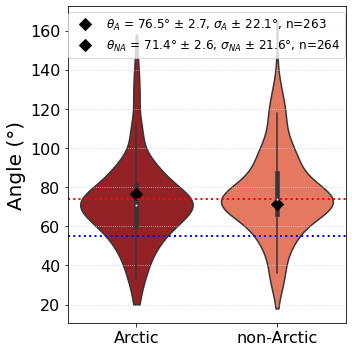

In [8]:
# Update 'Hydroclimate_Type' classification to abbreviations
AData['Hydroclimate_Type'] = AData['Hydroclimate'].apply(
    lambda x: 'A' if x == 6 else 'NA'
)

# Filter only Arctic and Non-Arctic rows
arctic_data = AData[AData['Hydroclimate_Type'].isin(['A', 'NA'])]

# Create violin plot
fig1, ax1 = plt.subplots(figsize=(5, 5))
sns.violinplot(data=arctic_data, x='Hydroclimate_Type', y='Angle',
               palette={'A': '#fb6a4a', 'NA': '#a50f15'},
               cut=0, inner='box', ax=ax1)

# Track handles and labels for custom legend
handles = []
labels = []

# Add mean diamonds and formatted legend entries
for i, group in enumerate(['A', 'NA']):
    group_data = arctic_data[arctic_data['Hydroclimate_Type'] == group]['Angle']
    mean_val = group_data.mean()
    std_val = group_data.std()
    n = len(group_data)
    
    # 95% CI
    ci = stats.t.interval(0.95, df=n-1, loc=mean_val, scale=std_val/np.sqrt(n))
    ci_half_width = (ci[1] - ci[0]) / 2
    
    # Plot diamond and collect handle
    handle = ax1.plot(i, mean_val, marker='D', color='black', markersize=8, linestyle='None')[0]
    
    # Build legend label with subscripts and sample size
    label = rf'$\theta_{{{group}}}$ = {mean_val:.1f}° ± {ci_half_width:.1f}, $\sigma_{{{group}}}$ ± {std_val:.1f}°, n={n}'
    handles.append(handle)
    labels.append(label)

# Horizontal lines for delta and fan averages
avg_delta_angle = AData['Angle'].mean()
avg_fan_angle = ADataFan['Angle'].mean()
ax1.axhline(avg_delta_angle, color='Red', linestyle=':', linewidth=2)
ax1.axhline(avg_fan_angle, color='Blue', linestyle=':', linewidth=2)

# Format plot to match the first plot
ax1.set_ylabel('Angle (°)', fontsize=20)
ax1.set_xlabel('', fontsize=12)
ax1.set_title('', fontsize=24)
ax1.tick_params(axis='y', labelsize=16)
ax1.tick_params(axis='x', labelsize=16)
ax1.set_xticklabels(['Arctic', 'non-Arctic'], fontsize=16)
ax1.grid(axis='y', linestyle=':', color='lightgrey')
ax1.legend(handles, labels, fontsize=12, loc='upper center')

plt.tight_layout()
plt.show()

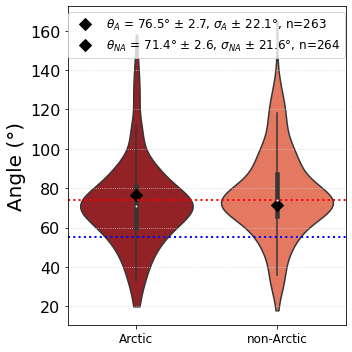

In [9]:
# Update 'Hydroclimate_Type' classification to abbreviations
AData['Hydroclimate_Type'] = AData['Hydroclimate'].apply(
    lambda x: 'A' if x == 6 else 'NA'
)

# Filter only Arctic and Non-Arctic rows
arctic_data = AData[AData['Hydroclimate_Type'].isin(['A', 'NA'])]

# Create violin plot
fig1, ax1 = plt.subplots(figsize=(5, 5))
sns.violinplot(data=arctic_data, x='Hydroclimate_Type', y='Angle',
               palette={'A': '#fb6a4a', 'NA': '#a50f15'},
               cut=0, inner='box', ax=ax1)

# Track handles and labels for custom legend
handles = []
labels = []

# Add mean diamonds and formatted legend entries
for i, group in enumerate(['A', 'NA']):
    group_data = arctic_data[arctic_data['Hydroclimate_Type'] == group]['Angle']
    mean_val = group_data.mean()
    std_val = group_data.std()
    n = len(group_data)
    
    # 95% CI
    ci = stats.t.interval(0.95, df=n-1, loc=mean_val, scale=std_val/np.sqrt(n))
    ci_half_width = (ci[1] - ci[0]) / 2
    
    # Plot diamond and collect handle
    handle = ax1.plot(i, mean_val, marker='D', color='black', markersize=8, linestyle='None')[0]
    
    # Build legend label with subscripts and sample size
    label = rf'$\theta_{{{group}}}$ = {mean_val:.1f}° ± {ci_half_width:.1f}, $\sigma_{{{group}}}$ ± {std_val:.1f}°, n={n}'
    handles.append(handle)
    labels.append(label)

# Horizontal lines for delta and fan averages
avg_delta_angle = AData['Angle'].mean()
avg_fan_angle = ADataFan['Angle'].mean()
ax1.axhline(avg_delta_angle, color='Red', linestyle=':', linewidth=2)
ax1.axhline(avg_fan_angle, color='Blue', linestyle=':', linewidth=2)

# Format plot to match the first plot
ax1.set_ylabel('Angle (°)', fontsize=20)
ax1.set_xlabel('', fontsize=12)
ax1.set_title('', fontsize=24)
ax1.tick_params(axis='y', labelsize=16)
ax1.tick_params(axis='x', labelsize=12)
ax1.set_xticklabels(['Arctic', 'non-Arctic'], fontsize=12)
ax1.grid(axis='y', linestyle=':', color='lightgrey')
ax1.legend(handles, labels, fontsize=12, loc='upper center')

plt.tight_layout()
plt.show()

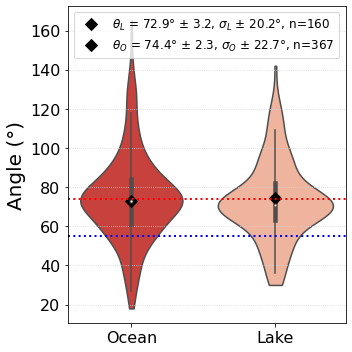

In [12]:
#Figure 7c 

# Copy relevant columns
AData_combined = AData[['Type', 'Angle', 'Hydroclimate', 'Termination']].copy()

# Classify Lake vs Ocean
AData_combined['Waterbody_Type'] = AData_combined['Termination'].apply(
    lambda x: 'Lake' if str(x).strip().lower() == 'lake' else 'Ocean'
)

# Create figure
fig, ax1 = plt.subplots(figsize=(5, 5))

# Bottom Plot: Lake vs Ocean
termination_data = AData_combined[AData_combined['Waterbody_Type'].isin(['Lake', 'Ocean'])]
sns.violinplot(data=termination_data, x='Waterbody_Type', y='Angle',
               palette={'Lake': '#fcae91', 'Ocean': '#de2d26'},
               cut=0, inner='box', ax=ax1)

# Track handles and labels for custom legend
handles = []
labels = []

# Add mean diamonds and formatted legend entries
for i, group in enumerate(['Lake', 'Ocean']):
    group_data = termination_data[termination_data['Waterbody_Type'] == group]['Angle']
    mean_val = group_data.mean()
    std_val = group_data.std()
    n = len(group_data)
    
    # 95% CI
    ci = stats.t.interval(0.95, df=n-1, loc=mean_val, scale=std_val/np.sqrt(n))
    ci_half_width = (ci[1] - ci[0]) / 2
    
    # Map to abbreviations for legend subscripts
    abbr = {'Lake': 'L', 'Ocean': 'O'}.get(group, group)
    
    # Plot diamond and collect handle
    handle = ax1.plot(i, mean_val, marker='D', color='black', markersize=8, linestyle='None')[0]
    
    # Build legend label with subscripts and sample size
    label = rf'$\theta_{{{abbr}}}$ = {mean_val:.1f}° ± {ci_half_width:.1f}, $\sigma_{{{abbr}}}$ ± {std_val:.1f}°, n={n}'
    handles.append(handle)
    labels.append(label)

# Horizontal lines for delta and fan averages
avg_delta_angle = AData['Angle'].mean()
avg_fan_angle = ADataFan['Angle'].mean()
ax1.axhline(avg_delta_angle, color='Red', linestyle=':', linewidth=2)
ax1.axhline(avg_fan_angle, color='Blue', linestyle=':', linewidth=2)

# Format plot to match Delta Types and Arctic/Non-Arctic
ax1.set_ylabel('Angle (°)', fontsize=20)
ax1.set_xlabel('', fontsize=24)
ax1.set_title('', fontsize=24)
ax1.tick_params(axis='y', labelsize=16)
ax1.tick_params(axis='x', labelsize=16)
ax1.set_xticklabels(
    [f"{t}"
     for t in termination_data['Waterbody_Type'].unique()],
    rotation=0, ha='center', fontsize=16
)
ax1.legend(handles, labels, fontsize=12, loc='upper center')
ax1.grid(axis='y', linestyle=':', color='lightgrey')

plt.tight_layout()
plt.show()

C:\Users\lukej\AppData\Local\Temp\ipykernel_38552\3683222178.py:67: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


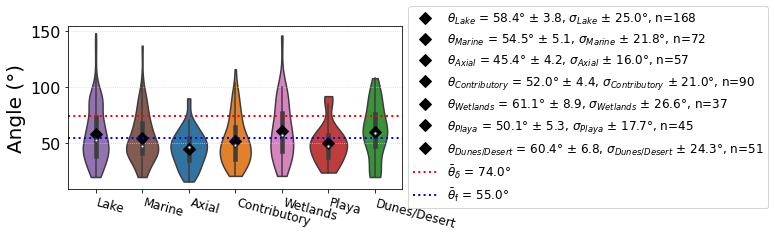

In [11]:
# Fluvial Fan Types Plot
fan_data = ADataFan[ADataFan['Type'].isin(['Axial', 'Contributory', 'Dunes/Desert', 'Playa', 'Lake', 'Marine', 'Wetlands'])]

# Check if fan_data is empty
if fan_data.empty:
    print("fan_data is empty. Available types in ADataFan['Type']:", ADataFan['Type'].unique())
    raise ValueError("fan_data is empty. Check ADataFan['Type'] for valid fan types.")

# Define a fallback color palette for all fan types
default_colors = {
    'Axial': '#1f77b4', 'Contributory': '#ff7f0e', 'Dunes/Desert': '#2ca02c',
    'Playa': '#d62728', 'Lake': '#9467bd', 'Marine': '#8c564b', 'Wetlands': '#e377c2'
}
# Use provided type_colors if available and valid, else default_colors
type_colors = type_colors if 'type_colors' in globals() and all(t in type_colors for t in fan_data['Type'].unique()) else default_colors

fig2, ax2 = plt.subplots(figsize=(6, 3))
sns.violinplot(data=fan_data, x='Type', y='Angle', palette=type_colors, cut=0, inner='box', ax=ax2)

# Track handles and labels for custom legend
handles = []
labels = []

# Add mean diamonds and formatted legend entries
for i, group in enumerate(fan_data['Type'].unique()):
    group_data = fan_data[fan_data['Type'] == group]['Angle']
    mean_val = group_data.mean()
    std_val = group_data.std()
    n = len(group_data)
    
    # 95% CI
    ci = stats.t.interval(0.95, df=n-1, loc=mean_val, scale=std_val/np.sqrt(n))
    ci_half_width = (ci[1] - ci[0]) / 2
    
    # Plot diamond and collect handle
    handle = ax2.plot(i, mean_val, marker='D', color='black', markersize=8, linestyle='None')[0]
    
    # Build legend label with subscripts and sample size
    label = rf'$\theta_{{{group}}}$ = {mean_val:.1f}° ± {ci_half_width:.1f}, $\sigma_{{{group}}}$ ± {std_val:.1f}°, n={n}'
    handles.append(handle)
    labels.append(label)

# Add horizontal lines for delta and fan averages with legend entries
avg_delta_angle = AData['Angle'].mean()
avg_fan_angle = ADataFan['Angle'].mean()
line1 = ax2.axhline(avg_delta_angle, color='Red', linestyle=':', linewidth=2)
line2 = ax2.axhline(avg_fan_angle, color='Blue', linestyle=':', linewidth=2)
handles.append(line1)
labels.append(rf'$\bar{{\theta}}_{{\delta}}$ = {avg_delta_angle:.1f}°')
handles.append(line2)
labels.append(rf'$\bar{{\theta}}_{{\mathrm{{f}}}}$ = {avg_fan_angle:.1f}°')

# Update x-tick labels with type counts
type_counts = fan_data['Type'].value_counts()
ax2.set_xticklabels([f"{t}" for t in fan_data['Type'].unique()],
                    rotation=-15, ha='left', fontsize=16)

# Format plot to match Delta Types, Arctic/Non-Arctic, and Lake/Ocean
ax2.set_ylabel('Angle (°)', fontsize=20)
ax2.set_xlabel('', fontsize=12)
ax2.set_title('', fontsize=24)
ax2.tick_params(axis='y', labelsize=16)
ax2.tick_params(axis='x', labelsize=12)
ax2.legend(handles, labels, fontsize=12, loc='center left', bbox_to_anchor=(1, 0.5))
ax2.grid(axis='y', linestyle=':', color='lightgrey')

plt.tight_layout()
plt.show()

ADataFan columns: ['Name', 'Avulsion', 'Angle', 'Order', 'Hydroclimate', 'Type', 'Planform', 'Group']
AData columns: ['Name', 'Bifurcation', 'Angle', 'Order', 'Hydroclimate', 'Type', 'Termination', 'Group', 'Hydroclimate_Type']
Unique Planform values in fan_data: ['I' 'II' 'V' 'IV' 'VI' 'III']
Planform value counts: {'I': 230, 'IV': 134, 'V': 85, 'III': 30, 'II': 28, 'VI': 13}
Planform color assignments: {'I': '#1f77b4', 'II': '#ff7f0e', 'III': '#2ca02c', 'IV': '#d62728', 'V': '#9467bd', 'VI': '#8c564b'}


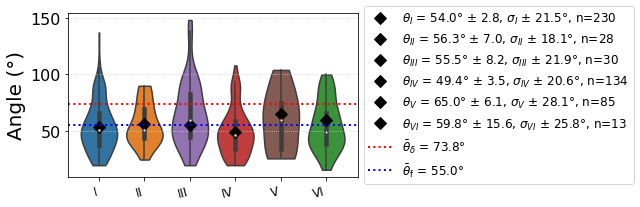

In [14]:
# Diagnostic: Print available columns
print("ADataFan columns:", list(ADataFan.columns))
print("AData columns:", list(AData.columns))

# Verify column existence
required_columns = ['Planform', 'Angle']
available_columns = ADataFan.columns.tolist()
if not all(col in available_columns for col in required_columns):
    missing = [col for col in required_columns if col in available_columns]
    for col in missing:
        similar = get_close_matches(col, available_columns, n=3, cutoff=0.6)
        print(f"Suggested columns similar to '{col}': {similar}")
    raise KeyError(f"Missing columns in ADataFan: {missing}. Available columns: {available_columns}")
if 'Angle' not in AData.columns:
    raise KeyError(f"'Angle' column missing in AData. Available columns: {list(AData.columns)}")

# Fluvial Fan Planform Plot
# Filter for valid Planform values (I–VI)
valid_planforms = ['I', 'II', 'III', 'IV', 'V', 'VI']
fan_data = ADataFan[ADataFan['Planform'].isin(valid_planforms)]

# Check if fan_data is empty
if fan_data.empty:
    print("fan_data is empty. Available planforms in ADataFan['Planform']:", ADataFan['Planform'].unique())
    raise ValueError("fan_data is empty. Expected Planform values: I, II, III, IV, V, VI")

# Diagnostic: Print unique Planform values and counts
print("Unique Planform values in fan_data:", fan_data['Planform'].unique())
print("Planform value counts:", fan_data['Planform'].value_counts().to_dict())

# Define a fallback color palette
default_colors = {
    'Axial': '#1f77b4', 'Contributory': '#ff7f0e', 'Dunes/Desert': '#2ca02c',
    'Playa': '#d62728', 'Lake': '#9467bd', 'Marine': '#8c564b', 'Wetlands': '#e377c2'
}

# Assign colors to Planform values (I–VI, sequential order)
unique_planforms = sorted(fan_data['Planform'].unique())  # Sort for consistent order (I, II, ...)
color_keys = list(default_colors.keys())[:len(unique_planforms)]  # Take enough color keys
planform_colors = {pf: default_colors[ck] for pf, ck in zip(unique_planforms, color_keys)}

# Use provided type_colors if available and valid, else planform_colors
type_colors = type_colors if 'type_colors' in globals() and all(pf in type_colors for pf in unique_planforms) else planform_colors

# Diagnostic: Print color assignments
print("Planform color assignments:", planform_colors)

fig2, ax2 = plt.subplots(figsize=(6, 3))  # Original size
# Try slightly wider if still small: fig2, ax2 = plt.subplots(figsize=(6.5, 3))
sns.violinplot(data=fan_data, x='Planform', y='Angle', palette=type_colors, cut=0, inner='box', width=0.8, scale='width', ax=ax2)

# Track handles and labels for custom legend
handles = []
labels = []

# Add mean diamonds and formatted legend entries
for i, group in enumerate(unique_planforms):  # Use sorted order
    group_data = fan_data[fan_data['Planform'] == group]['Angle']
    mean_val = group_data.mean()
    std_val = group_data.std()
    n = len(group_data)
    
    # 95% CI
    ci = stats.t.interval(0.95, df=n-1, loc=mean_val, scale=std_val/np.sqrt(n))
    ci_half_width = (ci[1] - ci[0]) / 2
    
    # Plot diamond and collect handle
    handle = ax2.plot(i, mean_val, marker='D', color='black', markersize=8, linestyle='None')[0]
    
    # Build legend label with updated subscripts
    label = rf'$\theta_{{{group}}}$ = {mean_val:.1f}° ± {ci_half_width:.1f}, $\sigma_{{{group}}}$ ± {std_val:.1f}°, n={n}'
    handles.append(handle)
    labels.append(label)

# Add horizontal lines for delta and fan averages with legend entries
avg_delta_angle = AData['Angle'].mean()
avg_fan_angle = ADataFan['Angle'].mean()
line1 = ax2.axhline(avg_delta_angle, color='Red', linestyle=':', linewidth=2)
line2 = ax2.axhline(avg_fan_angle, color='Blue', linestyle=':', linewidth=2)
handles.append(line1)
labels.append(rf'$\bar{{\theta}}_{{\delta}}$ = {avg_delta_angle:.1f}°')
handles.append(line2)
labels.append(rf'$\bar{{\theta}}_{{\mathrm{{f}}}}$ = {avg_fan_angle:.1f}°')

# Update x-tick labels with planform values
ax2.set_xticklabels(unique_planforms, rotation=15, ha='right', fontsize=12)  # Original fontsize and rotation

# Format plot to match original style
ax2.set_ylabel('Angle (°)', fontsize=20)
ax2.set_xlabel('', fontsize=12)
ax2.set_title('', fontsize=24)
ax2.tick_params(axis='y', labelsize=16)
ax2.tick_params(axis='x', labelsize=12)
ax2.legend(handles, labels, fontsize=12, loc='center left', bbox_to_anchor=(1, 0.5))
# Try smaller legend fontsize if crowding: ax2.legend(handles, labels, fontsize=10, loc='center left', bbox_to_anchor=(1, 0.5))
# Or adjust legend position: ax2.legend(handles, labels, fontsize=12, loc='upper left', bbox_to_anchor=(1, 1))
ax2.grid(axis='y', linestyle=':', color='lightgrey')

plt.tight_layout(rect=[0, 0, 1.5, 1])  # Adjust margins to give more space for violins
plt.show()

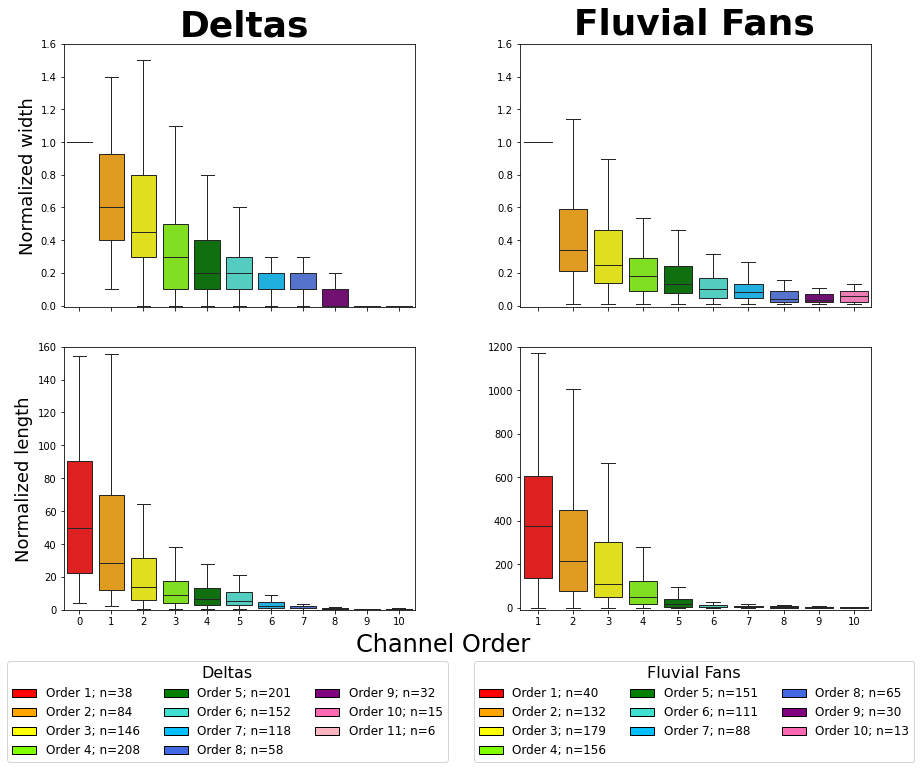

In [33]:
# --- Custom palette ---
custom_palette = [
    "red", "orange", "yellow", "chartreuse", "green",
    "turquoise", "deepskyblue", "royalblue", "purple", "hotpink", "lightpink"
]

# --- Function to create boxplots ---
def generate_boxplot(ax, x, y, xlabel, ylabel, ylim, order_counts):
    sns.boxplot(
        x=x,
        y=y,
        width=0.8,
        linewidth=1,
        fliersize=0,
        palette=custom_palette[:len(order_counts)],
        data=pd.DataFrame({'x': x, 'y': y}),
        ax=ax
    )
    
    ax.set_xlabel(xlabel, fontsize=18)
    ax.set_ylabel(ylabel, fontsize=18)
    ax.set_ylim(ylim)
    ax.set_facecolor('none')
    ax.grid(False)

# --- Count occurrences ---
order_counts_LWData = LWData.ChannelOrder.value_counts().sort_index()
order_counts_LWDataFan = LWDataFan.ChannelOrder.value_counts().sort_index()

# --- 2x2 subplots ---
fig, axs = plt.subplots(2, 2, figsize=(12, 9.5), sharex='col')

# Top row: Widths
generate_boxplot(axs[0, 0], LWData.ChannelOrder, LWData.NormChannelWidth,
                 '', 'Normalized width', (-.01, 1.6), order_counts_LWData)
generate_boxplot(axs[0, 1], LWDataFan.ChannelOrder, LWDataFan.NormChannelWidth,
                 '', '', (-.01, 1.6), order_counts_LWDataFan)

# Bottom row: Lengths
generate_boxplot(axs[1, 0], LWData.ChannelOrder, LWData.NormChannelLength,
                 '', 'Normalized length', (-.1, 160), order_counts_LWData)
generate_boxplot(axs[1, 1], LWDataFan.ChannelOrder, LWDataFan.NormChannelLength,
                 '', '', (-10, 1200), order_counts_LWDataFan)

# Remove top row x-axis labels
for ax in axs[0, :]:
    ax.set_xlabel("")
# Remove right column y-axis labels
for ax in axs[:, 1]:
    ax.set_ylabel("")

# Format x-axis ticks to remove ".0"
def remove_decimal_zero(x, pos):
    return f'{int(x)}'
for ax in axs[:, 0]:
    ax.xaxis.set_major_formatter(FuncFormatter(remove_decimal_zero))

# Central x-axis label
fig.text(0.5, .05, 'Channel Order', ha='center', fontsize=24)

# --- Column group labels ---
fig.text(0.27, 0.94, "Deltas", ha='center', va='bottom', fontsize=36, fontweight="bold")
fig.text(0.79, 0.943, "Fluvial Fans", ha='center', va='bottom', fontsize=36, fontweight="bold")

# --- Build legends ---
legend_labels_deltas = [
    Patch(facecolor=color, edgecolor='black', linewidth=1,
          label=f'Order {int(order)}; n={int(count)}')
    for color, (order, count) in zip(custom_palette, zip(order_counts_LWData.index, order_counts_LWData))
]

legend_labels_fans = [
    Patch(facecolor=color, edgecolor='black', linewidth=1,
          label=f'Order {int(order)}; n={int(count)}')
    for color, (order, count) in zip(custom_palette, zip(order_counts_LWDataFan.index, order_counts_LWDataFan))
]

# Place legends below figure
fig.legend(handles=legend_labels_deltas, title="Deltas",
           fontsize=12, title_fontsize=16,
           loc="lower center", bbox_to_anchor=(0.25, -0.12), ncol=3)

fig.legend(handles=legend_labels_fans, title="Fluvial Fans",
           fontsize=12, title_fontsize=16,
           loc="lower center", bbox_to_anchor=(0.79, -0.12), ncol=3)

# Adjust layout to leave space at top/bottom
plt.tight_layout(pad=0.4, rect=[0, 0.08, 1, 0.95])
plt.subplots_adjust(hspace=0.15, wspace=0.3)

# --- Show final figure ---
plt.show()

In [35]:
from scipy.stats import shapiro, ks_2samp, levene, ttest_ind, ttest_rel

# Function to perform normality test and return the result
def perform_normality_test(data1, data2, name1, name2):
    _, p_value_shapiro1 = shapiro(data1)
    _, p_value_shapiro2 = shapiro(data2)
    _, p_value_ks = ks_2samp(data1, data2)
    
    print(f"===== Testing for Normality =====")
    print(f"Normality Test for {name1}: P-value (Shapiro-Wilk) = {p_value_shapiro1:.4f}")
    print(f"Normality Test for {name2}: P-value (Shapiro-Wilk) = {p_value_shapiro2:.4f}")
    print(f"Kolmogorov-Smirnov Test: P-value = {p_value_ks:.4f}")
    print("Interpretation: A low p-value (< 0.05) suggests that the data may not be normally distributed.")
    print("\n")

# Function to perform Levene's test and return the result
def perform_variance_test(data1, data2, name1, name2):
    _, p_value_levene = levene(data1, data2)
    
    print(f"===== Testing for Variances =====")
    print(f"Levene's Test for {name1} and {name2}: P-value = {p_value_levene:.4f}")
    print("Interpretation: A low p-value (< 0.05) suggests that the population variances are significantly different.")
    print("\n")

# Function to perform t-test (either independent or paired) and return the result
def perform_t_test(data1, data2, name1, name2, paired=False):
    if paired:
        _, p_value_ttest = ttest_rel(data1, data2)
        print(f"Paired T-Test for {name1} and {name2}: P-value = {p_value_ttest:.4f}")
    else:
        _, p_value_ttest = ttest_ind(data1, data2, equal_var=True)
        print(f"Independent Samples T-Test for {name1} and {name2} (Assuming Equal Variances): P-value = {p_value_ttest:.4f}")
        print("Interpretation: A low p-value (< 0.05) suggests that the means are significantly different.")
        
        _, p_value_ttest_welch = ttest_ind(data1, data2, equal_var=False)
        print(f"Welch's T-Test for {name1} and {name2} (Unequal Variances): P-value = {p_value_ttest_welch:.4f}")
        print("Interpretation: A low p-value (< 0.05) suggests that the means are significantly different.")
    
    print("\n")

# Assuming you have DataFrame variables AData and ADataFan containing the relevant data columns

# Perform tests for angles
perform_normality_test(AData['Angle'], ADataFan['Angle'], 'Delta Angles', 'Fluvial Fan Angles')
perform_variance_test(AData['Angle'], ADataFan['Angle'], 'Delta Angles', 'Fluvial Fan Angles')
perform_t_test(AData['Angle'], ADataFan['Angle'], 'Delta Angles', 'Fluvial Fan Angles')

# Perform tests for lengths
perform_normality_test(LWData['NormChannelLength'], LWDataFan['NormChannelLength'], 'Delta Lengths', 'Fluvial Fan Lengths')
perform_variance_test(LWData['NormChannelLength'], LWDataFan['NormChannelLength'], 'Delta Lengths', 'Fluvial Fan Lengths')
perform_t_test(LWData['NormChannelLength'], LWDataFan['NormChannelLength'], 'Delta Lengths', 'Fluvial Fan Lengths')

# Perform tests for widths
perform_normality_test(LWData['NormChannelWidth'], LWDataFan['NormChannelWidth'], 'Delta Widths', 'Fluvial Fan Widths')
perform_variance_test(LWData['NormChannelWidth'], LWDataFan['NormChannelWidth'], 'Delta Widths', 'Fluvial Fan Widths')
perform_t_test(LWData['NormChannelWidth'], LWDataFan['NormChannelWidth'], 'Delta Widths', 'Fluvial Fan Widths')

===== Testing for Normality =====
Normality Test for Delta Angles: P-value (Shapiro-Wilk) = 0.0000
Normality Test for Fluvial Fan Angles: P-value (Shapiro-Wilk) = 0.0000
Kolmogorov-Smirnov Test: P-value = 0.0000
Interpretation: A low p-value (< 0.05) suggests that the data may not be normally distributed.


===== Testing for Variances =====
Levene's Test for Delta Angles and Fluvial Fan Angles: P-value = 0.0201
Interpretation: A low p-value (< 0.05) suggests that the population variances are significantly different.


Independent Samples T-Test for Delta Angles and Fluvial Fan Angles (Assuming Equal Variances): P-value = 0.0000
Interpretation: A low p-value (< 0.05) suggests that the means are significantly different.
Welch's T-Test for Delta Angles and Fluvial Fan Angles (Unequal Variances): P-value = 0.0000
Interpretation: A low p-value (< 0.05) suggests that the means are significantly different.


===== Testing for Normality =====
Normality Test for Delta Lengths: P-value (Shapiro-

In [36]:
from scipy.stats import shapiro, kstest, ttest_1samp
import pandas as pd
import numpy as np

# Print unique Type values to confirm
print("Unique Type values in AData:", AData['Type'].unique())

# Subset data for River dominated and Tide-influenced deltas, excluding Wave-influenced
delta_data = AData[AData['Type'].isin(['River dominated', 'Tide-influenced'])]
river_deltas = delta_data[delta_data['Type'] == 'River dominated']
tide_deltas = delta_data[delta_data['Type'] == 'Tide-influenced']

# Check if datasets are sufficient
if len(river_deltas) < 3:
    print(f"Error: River dominated Deltas has {len(river_deltas)} samples, need at least 3.")
if len(tide_deltas) < 3:
    print(f"Error: Tide-influenced Deltas has {len(tide_deltas)} samples, need at least 3.")
if delta_data.empty:
    print("Error: No data for River dominated or Tide-influenced deltas.")
    raise ValueError("delta_data is empty. Check AData['Type'] for valid values.")

# Calculate the overall mean (excluding Wave-influenced)
overall_mean = AData[AData['Type'].isin(['River dominated', 'Tide-influenced'])]['Angle'].mean()
print(f"Overall Mean (River dominated and Tide-influenced): {overall_mean:.2f}")

# Normality tests (Shapiro-Wilk and KS)
def perform_normality_tests(data, name):
    if len(data) < 3:
        print(f"Cannot perform normality tests for {name}: Only {len(data)} samples, need at least 3.\n")
        return
    # Shapiro-Wilk Test
    _, p_value_shapiro = shapiro(data)
    p_status_shapiro = "p < 0.05" if p_value_shapiro < 0.05 else "p > 0.05"
    print(f"Shapiro-Wilk Test for {name}: P-value = {p_value_shapiro:.4f} ({p_status_shapiro})")
    print("Interpretation: A low p-value (< 0.05) suggests non-normality.")
    
    # KS Test (compare to normal distribution)
    mean = data.mean()
    std = data.std()
    _, p_value_ks = kstest(data, 'norm', args=(mean, std))
    p_status_ks = "p < 0.05" if p_value_ks < 0.05 else "p > 0.05"
    print(f"KS Test for {name}: P-value = {p_value_ks:.4f} ({p_status_ks})")
    print("Interpretation: A low p-value (< 0.05) suggests non-normality.\n")

# One-sample T-test (compare group mean to overall mean)
def perform_one_sample_t_test(data, overall_mean, name):
    if len(data) < 3:
        print(f"Cannot perform T-test for {name}: Only {len(data)} samples, need at least 3.\n")
        return
    _, p_value_ttest = ttest_1samp(data, overall_mean)
    p_status_ttest = "p < 0.05" if p_value_ttest < 0.05 else "p > 0.05"
    print(f"One-Sample T-Test for {name} vs Overall Mean: P-value = {p_value_ttest:.4f} ({p_status_ttest})")
    print(f"Interpretation: {'Mean is significantly different from the overall mean' if p_value_ttest < 0.05 else 'Mean is not significantly different from the overall mean'}.\n")

# Perform tests for River dominated deltas
print(f"Testing River dominated Deltas (n={len(river_deltas)}):")
perform_normality_tests(river_deltas['Angle'], 'River dominated Deltas')
perform_one_sample_t_test(river_deltas['Angle'], overall_mean, 'River dominated Deltas')

# Perform tests for Tide-influenced deltas
print(f"Testing Tide-influenced Deltas (n={len(tide_deltas)}):")
perform_normality_tests(tide_deltas['Angle'], 'Tide-influenced Deltas')
perform_one_sample_t_test(tide_deltas['Angle'], overall_mean, 'Tide-influenced Deltas')

Unique Type values in AData: ['River dominated' 'Wave-influenced' 'Tide-influenced']
Overall Mean (River dominated and Tide-influenced): 74.15
Testing River dominated Deltas (n=374):
Shapiro-Wilk Test for River dominated Deltas: P-value = 0.0000 (p < 0.05)
Interpretation: A low p-value (< 0.05) suggests non-normality.
KS Test for River dominated Deltas: P-value = 0.0002 (p < 0.05)
Interpretation: A low p-value (< 0.05) suggests non-normality.

One-Sample T-Test for River dominated Deltas vs Overall Mean: P-value = 0.6418 (p > 0.05)
Interpretation: Mean is not significantly different from the overall mean.

Testing Tide-influenced Deltas (n=139):
Shapiro-Wilk Test for Tide-influenced Deltas: P-value = 0.0337 (p < 0.05)
Interpretation: A low p-value (< 0.05) suggests non-normality.
KS Test for Tide-influenced Deltas: P-value = 0.3173 (p > 0.05)
Interpretation: A low p-value (< 0.05) suggests non-normality.

One-Sample T-Test for Tide-influenced Deltas vs Overall Mean: P-value = 0.4711 (p

In [37]:
from scipy.stats import shapiro, kstest, levene, ttest_ind


# Extracting non-Arctic and Arctic deltas
non_arctic_deltas = AData[AData['Hydroclimate'].isin(range(1, 6))]
arctic_deltas = AData[AData['Hydroclimate'] == 6]

# Normality tests (Shapiro-Wilk and KS)
def perform_normality_tests(data, name):
    # Shapiro-Wilk Test
    _, p_value_shapiro = shapiro(data)
    p_status_shapiro = "p < 0.05" if p_value_shapiro < 0.05 else "p > 0.05"
    print(f"Shapiro-Wilk Test for {name}: P-value = {p_value_shapiro:.4f} ({p_status_shapiro})")
    print("Interpretation: A low p-value (< 0.05) suggests non-normality.")
    
    # KS Test (compare to normal distribution)
    mean = data.mean()
    std = data.std()
    _, p_value_ks = kstest(data, 'norm', args=(mean, std))
    p_status_ks = "p < 0.05" if p_value_ks < 0.05 else "p > 0.05"
    print(f"KS Test for {name}: P-value = {p_value_ks:.4f} ({p_status_ks})")
    print("Interpretation: A low p-value (< 0.05) suggests non-normality.\n")

# Variance test (Levene's Test)
def perform_variance_test(data1, data2, name1, name2):
    _, p_value_levene = levene(data1, data2)
    p_status = "p < 0.05" if p_value_levene < 0.05 else "p > 0.05"
    print(f"Levene's Test for {name1} vs {name2}: P-value = {p_value_levene:.4f} ({p_status})")
    print("Interpretation: A low p-value (< 0.05) suggests unequal variances.\n")

# T-test (Independent and Welch's)
def perform_t_test(data1, data2, name1, name2):
    _, p_value_ttest = ttest_ind(data1, data2, equal_var=True)
    p_status_ttest = "p < 0.05" if p_value_ttest < 0.05 else "p > 0.05"
    print(f"Independent T-Test (Equal Variances) for {name1} vs {name2}: P-value = {p_value_ttest:.4f} ({p_status_ttest})")
    print(f"Interpretation: {'Means are significantly different' if p_value_ttest < 0.05 else 'Means are not significantly different'}.")
    
    _, p_value_ttest_welch = ttest_ind(data1, data2, equal_var=False)
    p_status_welch = "p < 0.05" if p_value_ttest_welch < 0.05 else "p > 0.05"
    print(f"Welch's T-Test (Unequal Variances) for {name1} vs {name2}: P-value = {p_value_ttest_welch:.4f} ({p_status_welch})")
    print(f"Interpretation: {'Means are significantly different' if p_value_ttest_welch < 0.05 else 'Means are not significantly different'}.\n")

# Perform tests for Non-Arctic deltas
perform_normality_tests(non_arctic_deltas['Angle'], 'Non-Arctic Deltas')
perform_variance_test(non_arctic_deltas['Angle'], arctic_deltas['Angle'], 'Non-Arctic Deltas', 'Arctic Deltas')
perform_t_test(non_arctic_deltas['Angle'], arctic_deltas['Angle'], 'Non-Arctic Deltas', 'Arctic Deltas')

# Perform tests for Arctic deltas
perform_normality_tests(arctic_deltas['Angle'], 'Arctic Deltas')
perform_t_test(arctic_deltas['Angle'], non_arctic_deltas['Angle'], 'Arctic Deltas', 'Non-Arctic Deltas')

Shapiro-Wilk Test for Non-Arctic Deltas: P-value = 0.0000 (p < 0.05)
Interpretation: A low p-value (< 0.05) suggests non-normality.
KS Test for Non-Arctic Deltas: P-value = 0.0116 (p < 0.05)
Interpretation: A low p-value (< 0.05) suggests non-normality.

Levene's Test for Non-Arctic Deltas vs Arctic Deltas: P-value = 0.5783 (p > 0.05)
Interpretation: A low p-value (< 0.05) suggests unequal variances.

Independent T-Test (Equal Variances) for Non-Arctic Deltas vs Arctic Deltas: P-value = 0.0081 (p < 0.05)
Interpretation: Means are significantly different.
Welch's T-Test (Unequal Variances) for Non-Arctic Deltas vs Arctic Deltas: P-value = 0.0081 (p < 0.05)
Interpretation: Means are significantly different.

Shapiro-Wilk Test for Arctic Deltas: P-value = 0.0000 (p < 0.05)
Interpretation: A low p-value (< 0.05) suggests non-normality.
KS Test for Arctic Deltas: P-value = 0.0032 (p < 0.05)
Interpretation: A low p-value (< 0.05) suggests non-normality.

Independent T-Test (Equal Variances) 

In [38]:
from scipy.stats import shapiro, levene, ttest_ind
import pandas as pd

# Merge 'AData' with 'df' to include lake/ocean classification
merged_data = AData.merge(df[['Name', 'Lake']], on='Name', how='inner')

# Subset for Lake and Ocean terminating deltas
lake_deltas = merged_data[merged_data['Lake'] == 'Lake']
ocean_deltas = merged_data[merged_data['Lake'] == 'Ocean']

# Normality test (Shapiro-Wilk)
def perform_normality_test(data, name):
    _, p_value_shapiro = shapiro(data)
    p_status = "p < 0.05" if p_value_shapiro < 0.05 else "p > 0.05"
    print(f"Shapiro-Wilk Test for {name}: P-value = {p_value_shapiro:.4f} ({p_status})")
    print("Interpretation: A low p-value (< 0.05) suggests non-normality.\n")

# Variance test (Levene's Test)
def perform_variance_test(data1, data2, name1, name2):
    _, p_value_levene = levene(data1, data2)
    p_status = "p < 0.05" if p_value_levene < 0.05 else "p > 0.05"
    print(f"Levene's Test for {name1} vs {name2}: P-value = {p_value_levene:.4f} ({p_status})")
    print("Interpretation: A low p-value (< 0.05) suggests unequal variances.\n")

# T-test (Independent and Welch's)
def perform_t_test(data1, data2, name1, name2):
    _, p_value_ttest = ttest_ind(data1, data2, equal_var=True)
    p_status_ttest = "p < 0.05" if p_value_ttest < 0.05 else "p > 0.05"
    print(f"Independent T-Test (Equal Variances) for {name1} vs {name2}: P-value = {p_value_ttest:.4f} ({p_status_ttest})")
    
    _, p_value_ttest_welch = ttest_ind(data1, data2, equal_var=False)
    p_status_welch = "p < 0.05" if p_value_ttest_welch < 0.05 else "p > 0.05"
    print(f"Welch's T-Test (Unequal Variances) for {name1} vs {name2}: P-value = {p_value_ttest_welch:.4f} ({p_status_welch})")
    print()

# Perform tests for Lake-terminating deltas
perform_normality_test(lake_deltas['Angle'], 'Lake-Terminating Deltas')
perform_variance_test(lake_deltas['Angle'], ocean_deltas['Angle'], 'Lake-Terminating Deltas', 'Ocean-Terminating Deltas')
perform_t_test(lake_deltas['Angle'], ocean_deltas['Angle'], 'Lake-Terminating Deltas', 'Ocean-Terminating Deltas')

# Perform tests for Ocean-terminating deltas
perform_normality_test(ocean_deltas['Angle'], 'Ocean-Terminating Deltas')
perform_t_test(ocean_deltas['Angle'], lake_deltas['Angle'], 'Ocean-Terminating Deltas', 'Lake-Terminating Deltas')

Shapiro-Wilk Test for Lake-Terminating Deltas: P-value = 0.0003 (p < 0.05)
Interpretation: A low p-value (< 0.05) suggests non-normality.

Levene's Test for Lake-Terminating Deltas vs Ocean-Terminating Deltas: P-value = 0.2454 (p > 0.05)
Interpretation: A low p-value (< 0.05) suggests unequal variances.

Independent T-Test (Equal Variances) for Lake-Terminating Deltas vs Ocean-Terminating Deltas: P-value = 0.4766 (p > 0.05)
Welch's T-Test (Unequal Variances) for Lake-Terminating Deltas vs Ocean-Terminating Deltas: P-value = 0.4575 (p > 0.05)

Shapiro-Wilk Test for Ocean-Terminating Deltas: P-value = 0.0000 (p < 0.05)
Interpretation: A low p-value (< 0.05) suggests non-normality.

Independent T-Test (Equal Variances) for Ocean-Terminating Deltas vs Lake-Terminating Deltas: P-value = 0.4766 (p > 0.05)
Welch's T-Test (Unequal Variances) for Ocean-Terminating Deltas vs Lake-Terminating Deltas: P-value = 0.4575 (p > 0.05)



In [39]:
from scipy.stats import shapiro, kstest, levene, ttest_1samp
import pandas as pd
import numpy as np

# Calculate overall fluvial fan mean
avg_fan_angle = ADataFan['Angle'].mean()
print(f"Overall Fluvial Fan Mean: {avg_fan_angle:.2f}")

# Count samples per fan type
fan_types = ADataFan['Type'].unique()
print(f"Fan Types: {fan_types}")
type_counts = ADataFan['Type'].value_counts()

# Filter fan types with 30 or more measurements (optional, based on prior landform analysis)
valid_fan_types = type_counts[type_counts >= 30].index.tolist()
print(f"Fan Types with >= 30 measurements: {valid_fan_types}")

# Subset data to valid fan types
fan_data_valid = ADataFan[ADataFan['Type'].isin(valid_fan_types)]

# Normality tests (Shapiro-Wilk and KS)
def perform_normality_tests(data, name):
    # Shapiro-Wilk Test
    _, p_value_shapiro = shapiro(data)
    p_status_shapiro = "p < 0.05" if p_value_shapiro < 0.05 else "p > 0.05"
    print(f"Shapiro-Wilk Test for {name}: P-value = {p_value_shapiro:.4f} ({p_status_shapiro})")
    print("Interpretation: A low p-value (< 0.05) suggests non-normality.")
    
    # KS Test (compare to normal distribution)
    mean = data.mean()
    std = data.std()
    _, p_value_ks = kstest(data, 'norm', args=(mean, std))
    p_status_ks = "p < 0.05" if p_value_ks < 0.05 else "p > 0.05"
    print(f"KS Test for {name}: P-value = {p_value_ks:.4f} ({p_status_ks})")
    print("Interpretation: A low p-value (< 0.05) suggests non-normality.\n")
    
    return p_value_shapiro, p_value_ks

# Variance test (Levene's Test)
def perform_variance_test(data1, data2, name1, name2):
    _, p_value_levene = levene(data1, data2)
    p_status = "p < 0.05" if p_value_levene < 0.05 else "p > 0.05"
    print(f"Levene's Test for {name1} vs {name2}: P-value = {p_value_levene:.4f} ({p_status})")
    print("Interpretation: A low p-value (< 0.05) suggests unequal variances.\n")
    return p_value_levene

# One-sample T-test (compare fan type mean to overall fan mean)
def perform_one_sample_t_test(data, overall_mean, name):
    _, p_value_ttest = ttest_1samp(data, overall_mean)
    p_status_ttest = "p < 0.05" if p_value_ttest < 0.05 else "p > 0.05"
    print(f"One-Sample T-Test for {name} vs Overall Fan Mean: P-value = {p_value_ttest:.4f} ({p_status_ttest})")
    print(f"Interpretation: {'Mean is significantly different from the overall fan mean' if p_value_ttest < 0.05 else 'Mean is not significantly different from the overall fan mean'}.\n")
    return p_value_ttest

# Initialize results list
results = []

# Perform tests for each valid fan type
for fan_type in valid_fan_types:
    fan_type_data = fan_data_valid[fan_data_valid['Type'] == fan_type]['Angle']
    sample_size = len(fan_type_data)
    print(f"\nTesting {fan_type} (n={sample_size}):")
    
    # Normality tests
    p_value_shapiro, p_value_ks = perform_normality_tests(fan_type_data, fan_type)
    
    # Levene's test (compare variance to all fluvial fans)
    p_value_levene = perform_variance_test(fan_type_data, ADataFan['Angle'], fan_type, "All Fluvial Fans")
    
    # One-sample T-test
    p_value_ttest = perform_one_sample_t_test(fan_type_data, avg_fan_angle, fan_type)
    
    # Store results
    results.append({
        'Fan Type': fan_type,
        'Sample Size (n)': sample_size,
        'Shapiro-Wilk P-value': p_value_shapiro,
        'KS P-value': p_value_ks,
        'Levene P-value': p_value_levene,
        'T-test Mean P-value': p_value_ttest
    })

# Create DataFrame
results_df = pd.DataFrame(results)

# Format p-values to 4 decimal places
results_df['Shapiro-Wilk P-value'] = results_df['Shapiro-Wilk P-value'].map('{:.4f}'.format)
results_df['KS P-value'] = results_df['KS P-value'].map('{:.4f}'.format)
results_df['Levene P-value'] = results_df['Levene P-value'].map('{:.4f}'.format)
results_df['T-test Mean P-value'] = results_df['T-test Mean P-value'].map('{:.4f}'.format)

# Description for table
description = """
Statistical Test Results Description:
- Fan Type: Type of fluvial fan (e.g., based on classification).
- Sample Size (n): Number of angle measurements (≥ 30).
- Shapiro-Wilk P-value: Tests normality; p < 0.05 suggests data is non-normal, p > 0.05 suggests data is normal.
- KS P-value: Tests normality; p < 0.05 suggests data is non-normal, p > 0.05 suggests data is normal.
- Levene P-value: Tests if variance differs from all fluvial fans; p < 0.05 suggests unequal variances, p > 0.05 suggests equal variances.
- T-test Mean P-value: Tests if fan type mean differs from overall fluvial fan mean; p < 0.05 indicates significant difference, p > 0.05 indicates no significant difference.
"""

# Print description and table
print(description)
print(results_df.to_string(index=False))

Overall Fluvial Fan Mean: 54.99
Fan Types: ['Lake' 'Marine' 'Axial' 'Contributory' 'Wetlands' 'Playa' 'Dunes/Desert']
Fan Types with >= 30 measurements: ['Lake', 'Contributory', 'Marine', 'Axial', 'Dunes/Desert', 'Playa', 'Wetlands']

Testing Lake (n=168):
Shapiro-Wilk Test for Lake: P-value = 0.0000 (p < 0.05)
Interpretation: A low p-value (< 0.05) suggests non-normality.
KS Test for Lake: P-value = 0.0881 (p > 0.05)
Interpretation: A low p-value (< 0.05) suggests non-normality.

Levene's Test for Lake vs All Fluvial Fans: P-value = 0.1232 (p > 0.05)
Interpretation: A low p-value (< 0.05) suggests unequal variances.

One-Sample T-Test for Lake vs Overall Fan Mean: P-value = 0.0813 (p > 0.05)
Interpretation: Mean is not significantly different from the overall fan mean.


Testing Contributory (n=90):
Shapiro-Wilk Test for Contributory: P-value = 0.0004 (p < 0.05)
Interpretation: A low p-value (< 0.05) suggests non-normality.
KS Test for Contributory: P-value = 0.2271 (p > 0.05)
Interpr

In [40]:
# Diagnostic: Verify Planform column
if 'Planform' not in ADataFan.columns:
    from difflib import get_close_matches
    similar = get_close_matches('Planform', ADataFan.columns, n=3, cutoff=0.6)
    raise KeyError(f"'Planform' column missing in ADataFan. Suggested columns: {similar}. Available columns: {list(ADataFan.columns)}")

# Calculate overall fluvial fan mean
avg_fan_angle = ADataFan['Angle'].mean()
print(f"Overall Fluvial Fan Mean: {avg_fan_angle:.2f}")

# Count samples per planform
planforms = ADataFan['Planform'].unique()
print(f"Planforms: {planforms}")
planform_counts = ADataFan['Planform'].value_counts()

# Filter planforms with 30 or more measurements (optional, based on prior landform analysis)
valid_planforms = planform_counts[planform_counts >= 30].index.tolist()
print(f"Planforms with >= 30 measurements: {valid_planforms}")

# Subset data to valid planforms
planform_data_valid = ADataFan[ADataFan['Planform'].isin(valid_planforms)]

# Normality tests (Shapiro-Wilk and KS)
def perform_normality_tests(data, name):
    # Shapiro-Wilk Test
    _, p_value_shapiro = shapiro(data)
    p_status_shapiro = "p < 0.05" if p_value_shapiro < 0.05 else "p > 0.05"
    print(f"Shapiro-Wilk Test for {name}: P-value = {p_value_shapiro:.4f} ({p_status_shapiro})")
    print("Interpretation: A low p-value (< 0.05) suggests non-normality.")
    
    # KS Test (compare to normal distribution)
    mean = data.mean()
    std = data.std()
    _, p_value_ks = kstest(data, 'norm', args=(mean, std))
    p_status_ks = "p < 0.05" if p_value_ks < 0.05 else "p > 0.05"
    print(f"KS Test for {name}: P-value = {p_value_ks:.4f} ({p_status_ks})")
    print("Interpretation: A low p-value (< 0.05) suggests non-normality.\n")
    
    return p_value_shapiro, p_value_ks

# Variance test (Levene's Test)
def perform_variance_test(data1, data2, name1, name2):
    _, p_value_levene = levene(data1, data2)
    p_status = "p < 0.05" if p_value_levene < 0.05 else "p > 0.05"
    print(f"Levene's Test for {name1} vs {name2}: P-value = {p_value_levene:.4f} ({p_status})")
    print("Interpretation: A low p-value (< 0.05) suggests unequal variances.\n")
    return p_value_levene

# One-sample T-test (compare planform mean to overall fan mean)
def perform_one_sample_t_test(data, overall_mean, name):
    _, p_value_ttest = ttest_1samp(data, overall_mean)
    p_status_ttest = "p < 0.05" if p_value_ttest < 0.05 else "p > 0.05"
    print(f"One-Sample T-Test for {name} vs Overall Fan Mean: P-value = {p_value_ttest:.4f} ({p_status_ttest})")
    print(f"Interpretation: {'Mean is significantly different from the overall fan mean' if p_value_ttest < 0.05 else 'Mean is not significantly different from the overall fan mean'}.\n")
    return p_value_ttest

# Initialize results list
results = []

# Perform tests for each valid planform
for planform in valid_planforms:
    planform_data = planform_data_valid[planform_data_valid['Planform'] == planform]['Angle']
    sample_size = len(planform_data)
    print(f"\nTesting {planform} (n={sample_size}):")
    
    # Normality tests
    p_value_shapiro, p_value_ks = perform_normality_tests(planform_data, planform)
    
    # Levene's test (compare variance to all fluvial fans)
    p_value_levene = perform_variance_test(planform_data, ADataFan['Angle'], planform, "All Fluvial Fans")
    
    # One-sample T-test
    p_value_ttest = perform_one_sample_t_test(planform_data, avg_fan_angle, planform)
    
    # Store results
    results.append({
        'Planform': planform,
        'Sample Size (n)': sample_size,
        'Shapiro-Wilk P-value': p_value_shapiro,
        'KS P-value': p_value_ks,
        'Levene P-value': p_value_levene,
        'T-test Mean P-value': p_value_ttest
    })

# Create DataFrame
results_df = pd.DataFrame(results)

# Format p-values to 4 decimal places
results_df['Shapiro-Wilk P-value'] = results_df['Shapiro-Wilk P-value'].map('{:.4f}'.format)
results_df['KS P-value'] = results_df['KS P-value'].map('{:.4f}'.format)
results_df['Levene P-value'] = results_df['Levene P-value'].map('{:.4f}'.format)
results_df['T-test Mean P-value'] = results_df['T-test Mean P-value'].map('{:.4f}'.format)

# Description for table
description = """
Statistical Test Results Description:
- Planform: Planform category of fluvial fan (I, II, III, IV, V, VI).
- Sample Size (n): Number of angle measurements (≥ 30).
- Shapiro-Wilk P-value: Tests normality; p < 0.05 suggests data is non-normal, p > 0.05 suggests data is normal.
- KS P-value: Tests normality; p < 0.05 suggests data is non-normal, p > 0.05 suggests data is normal.
- Levene P-value: Tests if variance differs from all fluvial fans; p < 0.05 suggests unequal variances, p > 0.05 suggests equal variances.
- T-test Mean P-value: Tests if planform mean differs from overall fluvial fan mean; p < 0.05 indicates significant difference, p > 0.05 indicates no significant difference.
"""

# Print description and table
print(description)
print(results_df.to_string(index=False))

Overall Fluvial Fan Mean: 54.99
Planforms: ['I' 'II' 'V' 'IV' 'VI' 'III']
Planforms with >= 30 measurements: ['I', 'IV', 'V', 'III']

Testing I (n=230):
Shapiro-Wilk Test for I: P-value = 0.0000 (p < 0.05)
Interpretation: A low p-value (< 0.05) suggests non-normality.
KS Test for I: P-value = 0.0617 (p > 0.05)
Interpretation: A low p-value (< 0.05) suggests non-normality.

Levene's Test for I vs All Fluvial Fans: P-value = 0.4101 (p > 0.05)
Interpretation: A low p-value (< 0.05) suggests unequal variances.

One-Sample T-Test for I vs Overall Fan Mean: P-value = 0.4936 (p > 0.05)
Interpretation: Mean is not significantly different from the overall fan mean.


Testing IV (n=134):
Shapiro-Wilk Test for IV: P-value = 0.0000 (p < 0.05)
Interpretation: A low p-value (< 0.05) suggests non-normality.
KS Test for IV: P-value = 0.1606 (p > 0.05)
Interpretation: A low p-value (< 0.05) suggests non-normality.

Levene's Test for IV vs All Fluvial Fans: P-value = 0.1715 (p > 0.05)
Interpretation: A 

In [41]:
# Column name
angle_column = 'Angle'

# Calculate overall means and sample sizes for deltas and fans
delta_overall_mean = AData[angle_column].mean()
delta_overall_n = AData[angle_column].count()
fan_overall_mean = ADataFan[angle_column].mean()
fan_overall_n = ADataFan[angle_column].count()

# Group by Name to get mean angles, sample sizes, and standard deviations for each landform
delta_stats = AData.groupby('Name')[angle_column].agg(['mean', 'count', 'std']).reset_index()
delta_stats.columns = ['Name', 'Mean Angle', 'n', 'StDev']
delta_stats['Group'] = 'Delta'

fan_stats = ADataFan.groupby('Name')[angle_column].agg(['mean', 'count', 'std']).reset_index()
fan_stats.columns = ['Name', 'Mean Angle', 'n', 'StDev']
fan_stats['Group'] = 'Fluvial Fan'

# Combine delta and fan stats
all_stats = pd.concat([delta_stats, fan_stats], ignore_index=True)

# Verify expected number of landforms
delta_count = len(delta_stats)
fan_count = len(fan_stats)
if delta_count != 40 or fan_count != 40:
    print(f"Warning: Expected 40 deltas and 40 fans, but found {delta_count} deltas and {fan_count} fans.")

# Function to perform t-test and format p-value
def compare_means(group_data, overall_data, overall_n, overall_label):
    # Extract angles
    group_angles = group_data[angle_column].dropna()
    overall_angles = overall_data[angle_column].dropna()
    
    # Perform Welch's t-test
    if len(group_angles) < 2 or len(overall_angles) < 2:
        return 'N/A'  # Insufficient samples for t-test
    t_stat, p_value = ttest_ind(group_angles, overall_angles, equal_var=False, nan_policy='omit')
    
    # Format p-value as requested
    return 'p > 0.05' if p_value > 0.05 else 'p = 0'

# Lists to store results
results = []

# Compare each landform against overall delta and fan means
for _, row in all_stats.iterrows():
    landform_name = row['Name']
    mean_angle = row['Mean Angle']
    n = row['n']
    stdev = row['StDev']  # Extract standard deviation
    group = row['Group']
    
    # Filter data for this landform
    if group == 'Delta':
        group_data = AData[AData['Name'] == landform_name]
    else:
        group_data = ADataFan[ADataFan['Name'] == landform_name]
    
    # Compare to overall delta mean
    p_delta = compare_means(group_data, AData, delta_overall_n, 'Delta')
    
    # Compare to overall fan mean
    p_fan = compare_means(group_data, ADataFan, fan_overall_n, 'Fan')
    
    # Store results
    results.append({
        'Landform': landform_name,
        'Group': group,
        'Mean Angle': mean_angle,
        'StDev': stdev,  # Add StDev to results
        'n': n,
        'p-value (vs. Delta)': p_delta,
        'p-value (vs. Fan)': p_fan
    })

# Create results DataFrame
results_df = pd.DataFrame(results)

# Sort by Group (Deltas first) and Mean Angle
results_df = results_df.sort_values(by=['Group', 'Mean Angle'], ascending=[True, True])

# Format the DataFrame
results_df['Mean Angle'] = results_df['Mean Angle'].round(2)
results_df['StDev'] = results_df['StDev'].round(2)  # Round StDev to 2 decimal places
# Handle NaN StDev for landforms with n=1 (where StDev is undefined)
results_df['StDev'] = results_df['StDev'].fillna('N/A')
# Truncate long names for display
results_df['Landform'] = results_df['Landform'].apply(lambda x: x[:12] + '…' if len(x) > 12 else x)

# Display the results
print("Landform Angle Comparison Results")
print("=" * 80)
print(f"Overall Delta Mean Angle: {delta_overall_mean:.2f}° (n={delta_overall_n})")
print(f"Overall Fluvial Fan Mean Angle: {fan_overall_mean:.2f}° (n={fan_overall_n})")
print("=" * 80)
print(results_df.to_string(index=False))
print("=" * 80)
print("Note: 'p > 0.05' indicates similarity, 'p = 0' indicates dissimilarity, 'N/A' indicates insufficient samples.")

Landform Angle Comparison Results
Overall Delta Mean Angle: 73.96° (n=527)
Overall Fluvial Fan Mean Angle: 54.99° (n=520)
     Landform       Group  Mean Angle  StDev  n p-value (vs. Delta) p-value (vs. Fan)
      Zambezi       Delta       59.33  26.76  3            p > 0.05          p > 0.05
          Pur       Delta       61.50  16.30  4            p > 0.05          p > 0.05
           Po       Delta       62.43  20.15  7            p > 0.05          p > 0.05
       Mekong       Delta       63.33  13.05  6            p > 0.05          p > 0.05
     Wax Lake       Delta       64.73  22.58 11            p > 0.05          p > 0.05
       Poyang       Delta       65.58  15.82 31               p = 0             p = 0
  Atchafalaya       Delta       65.87   9.97 23               p = 0             p = 0
        Rioni       Delta       67.00   9.90  2            p > 0.05          p > 0.05
      Krishna       Delta       67.67  20.03  3            p > 0.05          p > 0.05
          Red     

In [42]:
def compare_means(group_data, overall_data, overall_n, overall_label):
    group_angles = group_data[angle_column].dropna()
    overall_angles = overall_data[angle_column].dropna()
    
    if len(group_angles) < 2 or len(overall_angles) < 2:
        return 'N/A', 'N/A', 'N/A', 'N/A'
    
    t_stat, p_value = ttest_ind(group_angles, overall_angles, equal_var=False, nan_policy='omit')
    
    # Calculate standard deviations
    group_std = group_angles.std()
    overall_std = overall_angles.std()
    
    return p_value, group_std, overall_std, len(group_angles)

# Update results storage
results = []
for _, row in all_stats.iterrows():
    landform_name = row['Name']
    mean_angle = row['Mean Angle']
    n = row['n']
    group = row['Group']
    
    if group == 'Delta':
        group_data = AData[AData['Name'] == landform_name]
    else:
        group_data = ADataFan[ADataFan['Name'] == landform_name]
    
    p_delta, group_std_delta, delta_std, group_n_delta = compare_means(group_data, AData, delta_overall_n, 'Delta')
    p_fan, group_std_fan, fan_std, group_n_fan = compare_means(group_data, ADataFan, fan_overall_n, 'Fan')
    
    results.append({
        'Landform': landform_name,
        'Group': group,
        'Mean Angle': mean_angle,
        'n': n,
        'p-value (vs. Delta)': p_delta if p_delta == 'N/A' else f'{p_delta:.3f}',
        'p-value (vs. Fan)': p_fan if p_fan == 'N/A' else f'{p_fan:.3f}',
        'Group Std (vs. Delta)': group_std_delta if group_std_delta != 'N/A' else 'N/A',
        'Overall Delta Std': delta_std if delta_std != 'N/A' else 'N/A',
        'Group Std (vs. Fan)': group_std_fan if group_std_fan != 'N/A' else 'N/A',
        'Overall Fan Std': fan_std if fan_std != 'N/A' else 'N/A'
    })

# Create and sort results DataFrame
results_df = pd.DataFrame(results)
results_df = results_df.sort_values(by=['Group', 'Mean Angle'], ascending=[True, True])
results_df['Mean Angle'] = results_df['Mean Angle'].round(2)
results_df['Landform'] = results_df['Landform'].apply(lambda x: x[:12] + '…' if len(x) > 12 else x)

# Display
print("Landform Angle Comparison Results")
print("=" * 80)
print(f"Overall Delta Mean Angle: {delta_overall_mean:.2f}° (n={delta_overall_n})")
print(f"Overall Fluvial Fan Mean Angle: {fan_overall_mean:.2f}° (n={fan_overall_n})")
print("=" * 80)
print(results_df.to_string(index=False))
print("=" * 80)

Landform Angle Comparison Results
Overall Delta Mean Angle: 73.96° (n=527)
Overall Fluvial Fan Mean Angle: 54.99° (n=520)
     Landform       Group  Mean Angle  n p-value (vs. Delta) p-value (vs. Fan)  Group Std (vs. Delta)  Overall Delta Std  Group Std (vs. Fan)  Overall Fan Std
      Zambezi       Delta       59.33  3               0.444             0.805              26.764404          21.974156            26.764404        22.928682
          Pur       Delta       61.50  4               0.224             0.484              16.299284          21.974156            16.299284        22.928682
           Po       Delta       62.43  7               0.182             0.369              20.148260          21.974156            20.148260        22.928682
       Mekong       Delta       63.33  6               0.103             0.181              13.048627          21.974156            13.048627        22.928682
     Wax Lake       Delta       64.73 11               0.208             0.186     

In [43]:
# Define the check_normality function
def check_normality(p_value):
    return "Normal" if p_value > 0.05 else "Not Normal"

# Function to perform normality tests
def perform_normality_test(data, overall_mean, group, measurement_type):
    if len(data) < 3:
        return {
            'Group': group,
            'Measurement Type': measurement_type,
            'KS P-Value': None,
            'KS Normality': 'Insufficient data',
            'SW P-Value': None,
            'SW Normality': 'Insufficient data'
        }
    ks_test_result = kstest(data, 'norm', args=(overall_mean, data.std()))
    shapiro_test_result = shapiro(data)
    return {
        'Group': group,
        'Measurement Type': measurement_type,
        'KS P-Value': ks_test_result.pvalue,
        'KS Normality': check_normality(ks_test_result.pvalue),
        'SW P-Value': shapiro_test_result.pvalue,
        'SW Normality': check_normality(shapiro_test_result.pvalue)
    }

# Function to perform variance and t-tests
def perform_tests(data1, data2, group1, group2, measurement_type):
    if len(data1) < 3 or len(data2) < 3:
        return {
            'Group': f"{group1} vs {group2}",
            'Measurement Type': measurement_type,
            'Levene P-Value': None,
            'Levene Result': 'Insufficient data',
            'T P-Value': None,
            'T Result': 'Insufficient data',
            'T-Test Type': 'None'
        }
    # Levene's test for equality of variances
    _, p_value_levene = levene(data1, data2)
    
    # Independent t-test or Welch's t-test based on Levene's test result
    if p_value_levene < 0.05:
        _, p_value_t = ttest_ind(data1, data2, equal_var=False)
        t_test_type = "Welch's t-test"
    else:
        _, p_value_t = ttest_ind(data1, data2, equal_var=True)
        t_test_type = "Independent t-test"
    
    return {
        'Group': f"{group1} vs {group2}",
        'Measurement Type': measurement_type,
        'Levene P-Value': p_value_levene,
        'Levene Result': "Reject" if p_value_levene < 0.05 else "Fail to reject",
        'T P-Value': p_value_t,
        'T Result': "Reject" if p_value_t < 0.05 else "Fail to reject",
        'T-Test Type': t_test_type
    }

# Calculate overall means for normality tests and comparisons
overall_mean_length_delta = LWData['NormChannelLength'].mean()
overall_mean_width_delta = LWData['NormChannelWidth'].mean()
overall_mean_length_fan = LWDataFan['NormChannelLength'].mean()
overall_mean_width_fan = LWDataFan['NormChannelWidth'].mean()

# Initialize results list
results = []

# Perform normality tests for deltas
results.append(perform_normality_test(LWData['NormChannelLength'], overall_mean_length_delta, 'Delta', 'Length'))
results.append(perform_normality_test(LWData['NormChannelWidth'], overall_mean_width_delta, 'Delta', 'Width'))

# Perform normality tests for fluvial fans
results.append(perform_normality_test(LWDataFan['NormChannelLength'], overall_mean_length_fan, 'Fluvial Fan', 'Length'))
results.append(perform_normality_test(LWDataFan['NormChannelWidth'], overall_mean_width_fan, 'Fluvial Fan', 'Width'))

# Perform variance and t-tests for length and width
length_comparison = perform_tests(LWData['NormChannelLength'], LWDataFan['NormChannelLength'], 'Delta', 'Fluvial Fan', 'Length')
width_comparison = perform_tests(LWData['NormChannelWidth'], LWDataFan['NormChannelWidth'], 'Delta', 'Fluvial Fan', 'Width')
results.append(length_comparison)
results.append(width_comparison)

# Create DataFrame from results
results_df = pd.DataFrame(results)

# Format p-values to 4 decimal places where applicable
for col in ['KS P-Value', 'SW P-Value', 'Levene P-Value', 'T P-Value']:
    results_df[col] = results_df[col].apply(lambda x: f"{x:.4f}" if pd.notnull(x) else 'N/A')

# Fill NaN for non-applicable columns
results_df = results_df.fillna('N/A')

# Select key columns for clarity
results_df = results_df[['Group', 'Measurement Type', 'KS P-Value', 'KS Normality', 'SW P-Value', 'SW Normality', 
                         'Levene P-Value', 'Levene Result', 'T P-Value', 'T Result', 'T-Test Type']]

# Description for table
description = """
Statistical Test Results Description:
- Group: Delta, Fluvial Fan, or comparison (Delta vs Fluvial Fan).
- Measurement Type: Channel Length (NormChannelLength) or Width (NormChannelWidth).
- KS P-Value: Tests normality; p < 0.05 suggests non-normal, p > 0.05 suggests normal.
- KS Normality: Normal (p > 0.05) or Not Normal (p < 0.05).
- SW P-Value: Tests normality; p < 0.05 suggests non-normal, p > 0.05 suggests normal.
- SW Normality: Normal (p > 0.05) or Not Normal (p < 0.05).
- Levene P-Value: Tests if variances differ; p < 0.05 suggests unequal variances, p > 0.05 suggests equal variances.
- Levene Result: Reject (p < 0.05, unequal variances) or Fail to reject (p > 0.05, equal variances).
- T P-Value: Tests if means differ; p < 0.05 indicates significant difference, p > 0.05 indicates no significant difference.
- T Result: Reject (p < 0.05, means differ) or Fail to reject (p > 0.05, means similar).
- T-Test Type: Independent t-test (equal variances) or Welch's t-test (unequal variances).
"""

# Custom function to print table with separating lines
def print_table_with_lines(df):
    # Define column widths for alignment
    col_widths = {
        'Group': 20,
        'Measurement Type': 15,
        'KS P-Value': 12,
        'KS Normality': 12,
        'SW P-Value': 12,
        'SW Normality': 12,
        'Levene P-Value': 15,
        'Levene Result': 15,
        'T P-Value': 12,
        'T Result': 15,
        'T-Test Type': 15
    }
    
    # Header
    header = " | ".join(f"{col:<{col_widths[col]}}" for col in df.columns)
    print(description)
    print('-' * len(header))
    print(header)
    print('-' * len(header))
    
    # Rows with separators
    last_group = None
    for _, row in df.iterrows():
        if last_group is not None and row['Group'] != last_group:
            print('-' * len(header))
        row_str = " | ".join(f"{str(row[col]):<{col_widths[col]}}" for col in df.columns)
        print(row_str)
        last_group = row['Group']
    
    print('-' * len(header))

# Print table
print_table_with_lines(results_df)

# Summary of means
length_similarity = "similar" if length_comparison['T P-Value'] >= 0.05 else "not similar"
width_similarity = "similar" if width_comparison['T P-Value'] >= 0.05 else "not similar"
length_larger = "deltas" if overall_mean_length_delta > overall_mean_length_fan else "fluvial fans"
width_larger = "deltas" if overall_mean_width_delta > overall_mean_width_fan else "fluvial fans"

print("\nMean Comparison Summary:")
print(f"The delta and fluvial fan length means are {length_similarity}, with {length_larger} having a larger mean "
      f"(Delta: {overall_mean_length_delta:.2f}, Fluvial Fan: {overall_mean_length_fan:.2f}).")
print(f"The delta and fluvial fan width means are {width_similarity}, with {width_larger} having a larger mean "
      f"(Delta: {overall_mean_width_delta:.2f}, Fluvial Fan: {overall_mean_width_fan:.2f}).")


Statistical Test Results Description:
- Group: Delta, Fluvial Fan, or comparison (Delta vs Fluvial Fan).
- Measurement Type: Channel Length (NormChannelLength) or Width (NormChannelWidth).
- KS P-Value: Tests normality; p < 0.05 suggests non-normal, p > 0.05 suggests normal.
- KS Normality: Normal (p > 0.05) or Not Normal (p < 0.05).
- SW P-Value: Tests normality; p < 0.05 suggests non-normal, p > 0.05 suggests normal.
- SW Normality: Normal (p > 0.05) or Not Normal (p < 0.05).
- Levene P-Value: Tests if variances differ; p < 0.05 suggests unequal variances, p > 0.05 suggests equal variances.
- Levene Result: Reject (p < 0.05, unequal variances) or Fail to reject (p > 0.05, equal variances).
- T P-Value: Tests if means differ; p < 0.05 indicates significant difference, p > 0.05 indicates no significant difference.
- T Result: Reject (p < 0.05, means differ) or Fail to reject (p > 0.05, means similar).
- T-Test Type: Independent t-test (equal variances) or Welch's t-test (unequal varia

In [44]:
print(f"Delta Length Mean: {LWData['NormChannelLength'].mean():.2f}, Median: {LWData['NormChannelLength'].median():.2f}")
print(f"Delta Width Mean: {LWData['NormChannelWidth'].mean():.2f}, Median: {LWData['NormChannelWidth'].median():.2f}")
print(f"Fan Length Mean: {LWDataFan['NormChannelLength'].mean():.2f}, Median: {LWDataFan['NormChannelLength'].median():.2f}")
print(f"Fan Width Mean: {LWDataFan['NormChannelWidth'].mean():.2f}, Median: {LWDataFan['NormChannelWidth'].median():.2f}")

Delta Length Mean: 17.44, Median: 6.70
Delta Width Mean: 0.40, Median: 0.20
Fan Length Mean: 147.09, Median: 26.23
Fan Width Mean: 0.26, Median: 0.15


In [45]:
import pandas as pd
from scipy.stats import kstest, shapiro, levene, ttest_ind

# Function to perform normality tests
def perform_normality_test(data, group_name, measurement_type, order):
    if len(data) < 3:
        return {'KS P-Value': None, 'SW P-Value': None}
    ks_test_result = kstest(data, 'norm', args=(data.mean(), data.std()))
    shapiro_test_result = shapiro(data)
    return {
        f'KS P-Value ({group_name})': ks_test_result.pvalue,
        f'SW P-Value ({group_name})': shapiro_test_result.pvalue
    }

# Function to perform variance and t-tests
def perform_tests(data1, data2, measurement_type, order):
    if len(data1) < 3 or len(data2) < 3:
        return {'Levene P-Value': None, 'T P-Value': None}
    _, p_value_levene = levene(data1, data2)
    if p_value_levene < 0.05:
        _, p_value_t = ttest_ind(data1, data2, equal_var=False)
    else:
        _, p_value_t = ttest_ind(data1, data2, equal_var=True)
    return {
        'Levene P-Value': p_value_levene,
        'T P-Value': p_value_t
    }

# Use correct column name
order_column = 'ChannelOrder'

# Get unique orders from both datasets
orders = set(LWData[order_column].unique()).intersection(LWDataFan[order_column].unique())

# Initialize results list
results = []

# Measurements to compare
measurements = ['NormChannelLength', 'NormChannelWidth']

# Perform tests for each order and measurement
for order in sorted(orders):
    for measurement in measurements:
        delta_data = LWData[LWData[order_column] == order][measurement]
        fan_data = LWDataFan[LWDataFan[order_column] == order][measurement]
        if len(delta_data) >= 30 and len(fan_data) >= 30:
            delta_normality = perform_normality_test(delta_data, 'Delta', measurement, order)
            fan_normality = perform_normality_test(fan_data, 'Fan', measurement, order)
            comparison_tests = perform_tests(delta_data, fan_data, measurement, order)
            result = {
                'Order': order,
                'Measurement': measurement.replace('NormChannel', ''),
                **delta_normality,
                **fan_normality,
                **comparison_tests
            }
            results.append(result)
        else:
            print(f"Omitted comparison for Order {order}, {measurement}: "
                  f"Delta n={len(delta_data)}, Fan n={len(fan_data)} (requires n >= 30 for both).")

# Create DataFrame from results
results_df = pd.DataFrame(results)

# Format p-values as "p > 0.05" or "p = 0"
def format_p_value(p):
    if pd.notnull(p):
        return "p > 0.05" if p > 0.05 else "p = 0"
    return "N/A"

for col in ['KS P-Value (Delta)', 'SW P-Value (Delta)', 'KS P-Value (Fan)', 'SW P-Value (Fan)', 'Levene P-Value', 'T P-Value']:
    results_df[col] = results_df[col].apply(format_p_value)

# Custom function to print table with separating lines
def print_table_with_lines(df):
    col_widths = {
        'Order': 8,
        'Measurement': 12,
        'KS P-Value (Delta)': 15,
        'SW P-Value (Delta)': 15,
        'KS P-Value (Fan)': 15,
        'SW P-Value (Fan)': 15,
        'Levene P-Value': 15,
        'T P-Value': 12
    }
    description = """
Statistical Test Results Description:
- Order: Channel order (e.g., 1 for first-order).
- Measurement: Length (NormChannelLength) or Width (NormChannelWidth).
- KS P-Value (Delta/Fan): Normality test; p = 0 suggests non-normal, p > 0.05 suggests normal.
- SW P-Value (Delta/Fan): Normality test; p = 0 suggests non-normal, p > 0.05 suggests normal.
- Levene P-Value: Variance equality; p = 0 suggests unequal variances, p > 0.05 suggests equal variances.
- T P-Value: Mean comparison; p = 0 indicates significant difference, p > 0.05 indicates no significant difference.
Note: Only comparisons with n >= 30 for both delta and fan are included.
"""
    header = " | ".join(f"{col:<{col_widths[col]}}" for col in df.columns)
    print(description)
    print('-' * len(header))
    print(header)
    print('-' * len(header))
    last_order = None
    for _, row in df.iterrows():
        if last_order is not None and row['Order'] != last_order:
            print('-' * len(header))
        row_str = " | ".join(f"{str(row[col]):<{col_widths[col]}}" for col in df.columns)
        print(row_str)
        last_order = row['Order']
    print('-' * len(header))

# Print table
if not results_df.empty:
    print_table_with_lines(results_df)
else:
    print("No comparisons meet the n >= 30 sample size requirement for both delta and fan populations.")

Omitted comparison for Order 10, NormChannelLength: Delta n=15, Fan n=13 (requires n >= 30 for both).
Omitted comparison for Order 10, NormChannelWidth: Delta n=15, Fan n=13 (requires n >= 30 for both).

Statistical Test Results Description:
- Order: Channel order (e.g., 1 for first-order).
- Measurement: Length (NormChannelLength) or Width (NormChannelWidth).
- KS P-Value (Delta/Fan): Normality test; p = 0 suggests non-normal, p > 0.05 suggests normal.
- SW P-Value (Delta/Fan): Normality test; p = 0 suggests non-normal, p > 0.05 suggests normal.
- Levene P-Value: Variance equality; p = 0 suggests unequal variances, p > 0.05 suggests equal variances.
- T P-Value: Mean comparison; p = 0 indicates significant difference, p > 0.05 indicates no significant difference.
Note: Only comparisons with n >= 30 for both delta and fan are included.

----------------------------------------------------------------------------------------------------------------------------------------
Order    | Mea

C:\Users\lukej\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1953: RuntimeWarning: invalid value encountered in true_divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)
C:\Users\lukej\anaconda3\lib\site-packages\scipy\stats\morestats.py:1757: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "
C:\Users\lukej\anaconda3\lib\site-packages\scipy\stats\morestats.py:2603: RuntimeWarning: invalid value encountered in double_scalars
  W = numer / denom


In [46]:
import pandas as pd

# Function to create a pivot table of channel counts by type and order
def get_channel_counts(df, dataset_name):
    # Group by Type and ChannelOrder, count channels
    counts = df.groupby(['Type', 'ChannelOrder']).size().reset_index(name='Count')
    # Pivot to create a table with Type as rows, ChannelOrder as columns
    pivot_table = counts.pivot(index='Type', columns='ChannelOrder', values='Count').fillna(0).astype(int)
    # Ensure all orders are shown, even if no data (optional, can remove if not needed)
    pivot_table = pivot_table.reindex(columns=sorted(df['ChannelOrder'].unique()), fill_value=0)
    print(f"\nChannel Counts for {dataset_name}:")
    print(pivot_table.to_string())
    return pivot_table

# Get channel counts for deltas (LWData)
delta_counts = get_channel_counts(LWData, "Deltas (LWData)")

# Get channel counts for fluvial fans (LWDataFan)
fan_counts = get_channel_counts(LWDataFan, "Fluvial Fans (LWDataFan)")


Channel Counts for Deltas (LWData):
ChannelOrder     1.0   2.0   3.0   4.0   5.0   6.0   7.0   8.0   9.0   10.0  11.0
Type                                                                             
River-dominated    23    47    93   151   138   122    96    41    23    15     6
Tide-influenced    11    29    45    53    59    25    22    17     9     0     0
Wave-influenced     4     8     8     4     4     5     0     0     0     0     0

Channel Counts for Fluvial Fans (LWDataFan):
ChannelOrder  1   2   3   4   5   6   7   8   9   10
Type                                                
Axial         10  28  28  26  10   0   0   0   0   0
Contributory   8  23  30  29  27  22   6  10  10   6
Dunes/Desert   2   6  14  14  17   9  14   4   0   0
Lake           6  24  37  43  52  48  46  35  14   7
Marine         5  22  32  20  16  17  12   5   2   0
Playa          5  19  21  16  17   9   6   4   0   0
Wetlands       4  10  17   8  12   6   4   7   4   0


In [47]:
import pandas as pd
from scipy.stats import kstest, shapiro, levene, ttest_ind

# Function to perform normality tests
def perform_normality_test(data, group_name, measurement_type, delta_type):
    if len(data) < 3:
        return {'KS P-Value': None, 'SW P-Value': None}
    ks_test_result = kstest(data, 'norm', args=(data.mean(), data.std()))
    shapiro_test_result = shapiro(data)
    return {
        f'KS P-Value ({group_name})': ks_test_result.pvalue,
        f'SW P-Value ({group_name})': shapiro_test_result.pvalue
    }

# Function to perform variance and t-tests
def perform_tests(data1, data2, measurement_type, delta_type):
    if len(data1) < 3 or len(data2) < 3:
        return {'Levene P-Value': None, 'T P-Value': None}
    _, p_value_levene = levene(data1, data2)
    if p_value_levene < 0.05:
        _, p_value_t = ttest_ind(data1, data2, equal_var=False)
    else:
        _, p_value_t = ttest_ind(data1, data2, equal_var=True)
    return {
        'Levene P-Value': p_value_levene,
        'T P-Value': p_value_t
    }

# List of delta types
lw_delta_types = LWData['Type'].unique()
adata_delta_types = AData['Type'].unique()

# Calculate overall means
overall_mean_length = LWData['NormChannelLength'].mean()
overall_mean_width = LWData['NormChannelWidth'].mean()
overall_mean_angle = AData['Angle'].mean()

# Initialize results list
results = []

# Perform tests for LWData (lengths and widths)
for delta_type in lw_delta_types:
    # Channel lengths
    lengths = LWData.loc[LWData['Type'] == delta_type, 'NormChannelLength']
    if len(lengths) >= 3:
        length_normality = perform_normality_test(lengths, 'Type', 'Length', delta_type)
        length_tests = perform_tests(lengths, LWData['NormChannelLength'], 'Length', delta_type)
        results.append({
            'Delta Type': delta_type,
            'Measurement': 'Length',
            **length_normality,
            **length_tests
        })
    else:
        print(f"Omitted comparison for {delta_type}, Length: n={len(lengths)} (requires n >= 3).")
    
    # Channel widths
    widths = LWData.loc[LWData['Type'] == delta_type, 'NormChannelWidth']
    if len(widths) >= 3:
        width_normality = perform_normality_test(widths, 'Type', 'Width', delta_type)
        width_tests = perform_tests(widths, LWData['NormChannelWidth'], 'Width', delta_type)
        results.append({
            'Delta Type': delta_type,
            'Measurement': 'Width',
            **width_normality,
            **width_tests
        })
    else:
        print(f"Omitted comparison for {delta_type}, Width: n={len(widths)} (requires n >= 3).")

# Perform tests for AData (angles)
for delta_type in adata_delta_types:
    angles = AData.loc[AData['Type'] == delta_type, 'Angle']
    if len(angles) >= 3:
        angle_normality = perform_normality_test(angles, 'Type', 'Angle', delta_type)
        angle_tests = perform_tests(angles, AData['Angle'], 'Angle', delta_type)
        results.append({
            'Delta Type': delta_type,
            'Measurement': 'Angle',
            **angle_normality,
            **angle_tests
        })
    else:
        print(f"Omitted comparison for {delta_type}, Angle: n={len(angles)} (requires n >= 3).")

# Create DataFrame from results
results_df = pd.DataFrame(results)

# Format p-values as "p > 0.05" or "p = 0"
def format_p_value(p):
    if pd.notnull(p):
        return "p > 0.05" if p > 0.05 else "p = 0"
    return "N/A"

for col in ['KS P-Value (Type)', 'SW P-Value (Type)', 'Levene P-Value', 'T P-Value']:
    results_df[col] = results_df[col].apply(format_p_value)

# Custom function to print table with separating lines
def print_table_with_lines(df):
    col_widths = {
        'Delta Type': 15,
        'Measurement': 12,
        'KS P-Value (Type)': 15,
        'SW P-Value (Type)': 15,
        'Levene P-Value': 15,
        'T P-Value': 12
    }
    description = """
Statistical Test Results Description:
- Delta Type: River, Wave, Tide, or other delta type.
- Measurement: Length (NormChannelLength), Width (NormChannelWidth), or Angle.
- KS P-Value (Type): Normality test; p = 0 suggests non-normal, p > 0.05 suggests normal.
- SW P-Value (Type): Normality test; p = 0 suggests non-normal, p > 0.05 suggests normal.
- Levene P-Value: Variance equality; p = 0 suggests unequal variances, p > 0.05 suggests equal variances.
- T P-Value: Mean comparison; p = 0 indicates significant difference, p > 0.05 indicates no significant difference.
Note: Compares each delta type against the overall dataset; requires n >= 3.
"""
    header = " | ".join(f"{col:<{col_widths[col]}}" for col in df.columns)
    print(description)
    print('-' * len(header))
    print(header)
    print('-' * len(header))
    last_type = None
    for _, row in df.iterrows():
        if last_type is not None and row['Delta Type'] != last_type:
            print('-' * len(header))
        row_str = " | ".join(f"{str(row[col]):<{col_widths[col]}}" for col in df.columns)
        print(row_str)
        last_type = row['Delta Type']
    print('-' * len(header))

# Print table
if not results_df.empty:
    print_table_with_lines(results_df)
else:
    print("No comparisons meet the n >= 3 sample size requirement.")


Statistical Test Results Description:
- Delta Type: River, Wave, Tide, or other delta type.
- Measurement: Length (NormChannelLength), Width (NormChannelWidth), or Angle.
- KS P-Value (Type): Normality test; p = 0 suggests non-normal, p > 0.05 suggests normal.
- SW P-Value (Type): Normality test; p = 0 suggests non-normal, p > 0.05 suggests normal.
- Levene P-Value: Variance equality; p = 0 suggests unequal variances, p > 0.05 suggests equal variances.
- T P-Value: Mean comparison; p = 0 indicates significant difference, p > 0.05 indicates no significant difference.
Note: Compares each delta type against the overall dataset; requires n >= 3.

-------------------------------------------------------------------------------------------------------
Delta Type      | Measurement  | KS P-Value (Type) | SW P-Value (Type) | Levene P-Value  | T P-Value   
-------------------------------------------------------------------------------------------------------
River-dominated | Length       | p =

In [48]:
import pandas as pd
from scipy.stats import kstest, shapiro, levene, ttest_ind

# Function to perform normality tests (for completeness, though not used in output)
def perform_normality_test(data, group_name, measurement_type, delta_type):
    if len(data) < 3:
        return {'KS P-Value': None, 'SW P-Value': None}
    ks_test_result = kstest(data, 'norm', args=(data.mean(), data.std()))
    shapiro_test_result = shapiro(data)
    return {
        f'KS P-Value ({group_name})': ks_test_result.pvalue,
        f'SW P-Value ({group_name})': shapiro_test_result.pvalue
    }

# Function to perform variance and t-tests
def perform_tests(data1, data2, measurement_type, delta_type):
    if len(data1) < 3 or len(data2) < 3:
        return {'Levene P-Value': None, 'T P-Value': None, 'Mean': None}
    _, p_value_levene = levene(data1, data2)
    if p_value_levene < 0.05:
        _, p_value_t = ttest_ind(data1, data2, equal_var=False)
    else:
        _, p_value_t = ttest_ind(data1, data2, equal_var=True)
    return {
        'Levene P-Value': p_value_levene,
        'T P-Value': p_value_t,
        'Mean': data1.mean()  # Store mean for comparison
    }

# List of delta types
lw_delta_types = LWData['Type'].unique()
adata_delta_types = AData['Type'].unique()

# Calculate overall means
overall_mean_length = LWData['NormChannelLength'].mean()
overall_mean_width = LWData['NormChannelWidth'].mean()
overall_mean_angle = AData['Angle'].mean()

# Initialize results list
results = []

# Perform tests for LWData (lengths and widths)
for delta_type in lw_delta_types:
    # Channel lengths
    lengths = LWData.loc[LWData['Type'] == delta_type, 'NormChannelLength']
    if len(lengths) >= 3:
        length_normality = perform_normality_test(lengths, 'Type', 'Length', delta_type)
        length_tests = perform_tests(lengths, LWData['NormChannelLength'], 'Length', delta_type)
        results.append({
            'Delta Type': delta_type,
            'Measurement': 'Length',
            **length_normality,
            **length_tests
        })
    else:
        print(f"Omitted comparison for {delta_type}, Length: n={len(lengths)} (requires n >= 3).")
    
    # Channel widths
    widths = LWData.loc[LWData['Type'] == delta_type, 'NormChannelWidth']
    if len(widths) >= 3:
        width_normality = perform_normality_test(widths, 'Type', 'Width', delta_type)
        width_tests = perform_tests(widths, LWData['NormChannelWidth'], 'Width', delta_type)
        results.append({
            'Delta Type': delta_type,
            'Measurement': 'Width',
            **width_normality,
            **width_tests
        })
    else:
        print(f"Omitted comparison for {delta_type}, Width: n={len(widths)} (requires n >= 3).")

# Perform tests for AData (angles)
for delta_type in adata_delta_types:
    angles = AData.loc[AData['Type'] == delta_type, 'Angle']
    if len(angles) >= 3:
        angle_normality = perform_normality_test(angles, 'Type', 'Angle', delta_type)
        angle_tests = perform_tests(angles, AData['Angle'], 'Angle', delta_type)
        results.append({
            'Delta Type': delta_type,
            'Measurement': 'Angle',
            **angle_normality,
            **angle_tests
        })
    else:
        print(f"Omitted comparison for {delta_type}, Angle: n={len(angles)} (requires n >= 3).")

# Create DataFrame from results
results_df = pd.DataFrame(results)

# Format p-values as "p > 0.05" or "p = 0"
def format_p_value(p):
    if pd.notnull(p):
        return "p > 0.05" if p > 0.05 else "p = 0"
    return "N/A"

results_df['T P-Value'] = results_df['T P-Value'].apply(format_p_value)

# Summarize which means are significantly larger
print("\nSummary of Delta Types with Significantly Larger Means:")

for measurement in ['Length', 'Width', 'Angle']:
    significant_types = []
    measurement_df = results_df[results_df['Measurement'] == measurement]
    overall_mean = {
        'Length': overall_mean_length,
        'Width': overall_mean_width,
        'Angle': overall_mean_angle
    }[measurement]
    
    for _, row in measurement_df.iterrows():
        if row['T P-Value'] == 'p = 0' and pd.notnull(row['Mean']) and row['Mean'] > overall_mean:
            significant_types.append(row['Delta Type'])
    
    if significant_types:
        print(f"For {measurement}, {', '.join(significant_types)} {'has' if len(significant_types) == 1 else 'have'} "
              f"a significantly larger mean than the overall average.")
    else:
        print(f"For {measurement}, no delta types have a significantly larger mean than the overall average.")


Summary of Delta Types with Significantly Larger Means:
For Length, no delta types have a significantly larger mean than the overall average.
For Width, Wave-influenced, Tide-influenced have a significantly larger mean than the overall average.
For Angle, no delta types have a significantly larger mean than the overall average.


In [49]:
import pandas as pd
from scipy.stats import kstest, shapiro, ttest_1samp, levene

# Define the check_normality function
def check_normality(p_value):
    return "Normal" if p_value > 0.05 else "Not Normal"

# Function to perform normality tests
def perform_normality_test(data, overall_mean, fan_type, measurement_type):
    if len(data) == 0:
        return {
            'Fan Type': fan_type,
            'Measurement Type': measurement_type,
            'KS P-Value': None,
            'KS Normality': 'Insufficient data',
            'SW P-Value': None,
            'SW Normality': 'Insufficient data'
        }
    ks_test_result = kstest(data, 'norm', args=(overall_mean, data.std()))
    shapiro_test_result = shapiro(data)
    return {
        'Fan Type': fan_type,
        'Measurement Type': measurement_type,
        'KS P-Value': ks_test_result.pvalue,
        'KS Normality': check_normality(ks_test_result.pvalue),
        'SW P-Value': shapiro_test_result.pvalue,
        'SW Normality': check_normality(shapiro_test_result.pvalue)
    }

# Function to perform t-tests
def perform_t_test(data, overall_mean, fan_type, measurement_type):
    if len(data) == 0:
        return {
            'Fan Type': fan_type,
            'Measurement Type': measurement_type,
            'T-Test P-Value': None,
            'T-Test Result': 'Insufficient data',
            'Means Similar': 'Insufficient data'
        }
    t_statistic, p_value = ttest_1samp(data, overall_mean)
    means_similar = "Yes" if p_value >= 0.05 else "No"  # If p-value > 0.05, fail to reject, meaning the means are similar
    return {
        'Fan Type': fan_type,
        'Measurement Type': measurement_type,
        'T-Test P-Value': p_value,
        'T-Test Result': "Reject" if p_value < 0.05 else "Fail to reject",
        'Means Similar': means_similar  # Added column for whether the means are similar or not
    }

# Function to perform Levene's test for variance equality
def perform_levene_test(data, overall_data, fan_type, measurement_type):
    if len(data) == 0 or len(overall_data) == 0:
        return {
            'Fan Type': fan_type,
            'Measurement Type': measurement_type,
            'Levene P-Value': None,
            'Levene Result': 'Insufficient data'
        }
    _, p_value_levene = levene(data, overall_data)
    variances_similar = "Yes" if p_value_levene >= 0.05 else "No"
    return {
        'Fan Type': fan_type,
        'Measurement Type': measurement_type,
        'Levene P-Value': p_value_levene,
        'Levene Result': "Fail to reject" if p_value_levene >= 0.05 else "Reject",
        'Variance Similar': variances_similar
    }

# Calculate the overall mean of fan lengths, widths, and angles
overall_mean_length = LWDataFan['NormChannelLength'].mean()
overall_mean_width = LWDataFan['NormChannelWidth'].mean()
overall_mean_angle = ADataFan['Angle'].mean()  # Assuming 'Angle' column is from ADataFan

# Initialize lists to store the test results
length_results = []
width_results = []
angle_results = []

# Perform tests for fan lengths, widths, and angles
fan_types = LWDataFan['Type'].unique()
for fan_type in fan_types:
    # Fan lengths (from LWDataFan)
    lengths = LWDataFan.loc[LWDataFan['Type'] == fan_type, 'NormChannelLength']
    length_results.append(perform_normality_test(lengths, overall_mean_length, fan_type, 'Length'))
    length_results[-1].update(perform_t_test(lengths, overall_mean_length, fan_type, 'Length'))
    length_results[-1].update(perform_levene_test(lengths, LWDataFan['NormChannelLength'], fan_type, 'Length'))
    
    # Fan widths (from LWDataFan)
    widths = LWDataFan.loc[LWDataFan['Type'] == fan_type, 'NormChannelWidth']
    width_results.append(perform_normality_test(widths, overall_mean_width, fan_type, 'Width'))
    width_results[-1].update(perform_t_test(widths, overall_mean_width, fan_type, 'Width'))
    width_results[-1].update(perform_levene_test(widths, LWDataFan['NormChannelWidth'], fan_type, 'Width'))

    # Fan angles (from ADataFan)
    angles = ADataFan.loc[ADataFan['Type'] == fan_type, 'Angle']
    angle_results.append(perform_normality_test(angles, overall_mean_angle, fan_type, 'Angle'))
    angle_results[-1].update(perform_t_test(angles, overall_mean_angle, fan_type, 'Angle'))
    angle_results[-1].update(perform_levene_test(angles, ADataFan['Angle'], fan_type, 'Angle'))

# Create DataFrames from the results lists
length_results_df = pd.DataFrame(length_results)
width_results_df = pd.DataFrame(width_results)
angle_results_df = pd.DataFrame(angle_results)

# Combine the results into a single DataFrame
combined_results_df = pd.concat([length_results_df, width_results_df, angle_results_df], keys=['Lengths', 'Widths', 'Angles'], names=['Measurement', 'Index'])

# Format the table for easier reading
combined_results_df = combined_results_df[['Fan Type', 'Measurement Type', 'KS P-Value', 'KS Normality', 'SW P-Value', 'SW Normality', 
                                           'T-Test P-Value', 'T-Test Result', 'Means Similar', 'Levene P-Value', 'Levene Result', 'Variance Similar']]

# Display the combined results table
print(combined_results_df)



                       Fan Type Measurement Type    KS P-Value KS Normality  \
Measurement Index                                                             
Lengths     0              Lake           Length  1.783189e-32   Not Normal   
            1            Marine           Length  1.147898e-29   Not Normal   
            2             Axial           Length  1.555298e-12   Not Normal   
            3             Playa           Length  1.814099e-11   Not Normal   
            4      Contributory           Length  1.544995e-15   Not Normal   
            5          Wetlands           Length  3.623249e-27   Not Normal   
            6      Dunes/Desert           Length  4.901232e-31   Not Normal   
Widths      0              Lake            Width  7.068463e-17   Not Normal   
            1            Marine            Width  2.441292e-08   Not Normal   
            2             Axial            Width  3.829893e-05   Not Normal   
            3             Playa            Width  2.

In [50]:
import pandas as pd
from scipy.stats import kstest, shapiro, levene, ttest_ind

# Function to perform normality tests
def perform_normality_test(data, group_name, measurement_type, style):
    if len(data) < 3:
        return {'KS P-Value': None, 'SW P-Value': None}
    ks_test_result = kstest(data, 'norm', args=(data.mean(), data.std()))
    shapiro_test_result = shapiro(data)
    return {
        f'KS P-Value ({group_name})': ks_test_result.pvalue,
        f'SW P-Value ({group_name})': shapiro_test_result.pvalue
    }

# Function to perform variance and t-tests
def perform_tests(data1, data2, measurement_type, style):
    if len(data1) < 3 or len(data2) < 3:
        return {'Levene P-Value': None, 'T P-Value': None}
    _, p_value_levene = levene(data1, data2)
    if p_value_levene < 0.05:
        _, p_value_t = ttest_ind(data1, data2, equal_var=False)
    else:
        _, p_value_t = ttest_ind(data1, data2, equal_var=True)
    return {
        'Levene P-Value': p_value_levene,
        'T P-Value': p_value_t
    }

# List of fluvial fan termination styles
fan_styles = LWDataFan['Type'].unique()

# Calculate overall means
overall_mean_length = LWDataFan['NormChannelLength'].mean()
overall_mean_width = LWDataFan['NormChannelWidth'].mean()

# Initialize results list
results = []

# Perform tests for lengths (all styles)
for style in sorted(fan_styles):
    lengths = LWDataFan.loc[LWDataFan['Type'] == style, 'NormChannelLength']
    if len(lengths) >= 3:
        length_normality = perform_normality_test(lengths, 'Style', 'Length', style)
        length_tests = perform_tests(lengths, LWDataFan['NormChannelLength'], 'Length', style)
        results.append({
            'Termination Style': style,
            'Measurement': 'Length',
            **length_normality,
            **length_tests
        })
    else:
        print(f"Omitted comparison for {style}, Length: n={len(lengths)} (requires n >= 3).")

# Perform tests for widths (all styles)
for style in sorted(fan_styles):
    widths = LWDataFan.loc[LWDataFan['Type'] == style, 'NormChannelWidth']
    if len(widths) >= 3:
        width_normality = perform_normality_test(widths, 'Style', 'Width', style)
        width_tests = perform_tests(widths, LWDataFan['NormChannelWidth'], 'Width', style)
        results.append({
            'Termination Style': style,
            'Measurement': 'Width',
            **width_normality,
            **width_tests
        })
    else:
        print(f"Omitted comparison for {style}, Width: n={len(widths)} (requires n >= 3).")

# Create DataFrame from results
results_df = pd.DataFrame(results)

# Format p-values as "p > 0.05" or "p = 0"
def format_p_value(p):
    if pd.notnull(p):
        return "p > 0.05" if p > 0.05 else "p = 0"
    return "N/A"

for col in ['KS P-Value (Style)', 'SW P-Value (Style)', 'Levene P-Value', 'T P-Value']:
    results_df[col] = results_df[col].apply(format_p_value)

# Sort results: all lengths first, then all widths, by termination style within each
results_df = results_df.sort_values(by=['Measurement', 'Termination Style'], 
                                   key=lambda x: x.map({'Length': 0, 'Width': 1}) if x.name == 'Measurement' else x)

# Custom function to print table with separating lines
def print_table_with_lines(df):
    col_widths = {
        'Termination Style': 20,
        'Measurement': 12,
        'KS P-Value (Style)': 15,
        'SW P-Value (Style)': 15,
        'Levene P-Value': 15,
        'T P-Value': 12
    }
    description = """
Statistical Test Results Description:
- Termination Style: Fluvial fan termination style (e.g., Alluvial, Bajada).
- Measurement: Length (NormChannelLength) or Width (NormChannelWidth).
- KS P-Value (Style): Normality test; p = 0 suggests non-normal, p > 0.05 suggests normal.
- SW P-Value (Style): Normality test; p = 0 suggests non-normal, p > 0.05 suggests normal.
- Levene P-Value: Variance equality; p = 0 suggests unequal variances, p > 0.05 suggests equal variances.
- T P-Value: Mean comparison; p = 0 indicates significant difference, p > 0.05 indicates no significant difference.
Note: Compares each termination style against the overall fluvial fan dataset; requires n >= 3.
"""
    header = " | ".join(f"{col:<{col_widths[col]}}" for col in df.columns)
    print(description)
    print('-' * len(header))
    print(header)
    print('-' * len(header))
    last_style = None
    last_measurement = None
    for _, row in df.iterrows():
        if last_measurement != row['Measurement'] or (last_style is not None and row['Termination Style'] != last_style):
            print('-' * len(header))
        row_str = " | ".join(f"{str(row[col]):<{col_widths[col]}}" for col in df.columns)
        print(row_str)
        last_style = row['Termination Style']
        last_measurement = row['Measurement']
    print('-' * len(header))

# Print table
if not results_df.empty:
    print_table_with_lines(results_df)
else:
    print("No comparisons meet the n >= 3 sample size requirement.")


Statistical Test Results Description:
- Termination Style: Fluvial fan termination style (e.g., Alluvial, Bajada).
- Measurement: Length (NormChannelLength) or Width (NormChannelWidth).
- KS P-Value (Style): Normality test; p = 0 suggests non-normal, p > 0.05 suggests normal.
- SW P-Value (Style): Normality test; p = 0 suggests non-normal, p > 0.05 suggests normal.
- Levene P-Value: Variance equality; p = 0 suggests unequal variances, p > 0.05 suggests equal variances.
- T P-Value: Mean comparison; p = 0 indicates significant difference, p > 0.05 indicates no significant difference.
Note: Compares each termination style against the overall fluvial fan dataset; requires n >= 3.

--------------------------------------------------------------------------------------------------------------
Termination Style    | Measurement  | KS P-Value (Style) | SW P-Value (Style) | Levene P-Value  | T P-Value   
------------------------------------------------------------------------------------------

In [32]:
import pandas as pd

# Function to create a mean table by order or type
def create_mean_table(df, group_col, dataset_name, measurement_cols=['NormChannelLength', 'NormChannelWidth']):
    # Group by the specified column (ChannelOrder or Type) and calculate means and counts
    grouped = df.groupby(group_col)[measurement_cols].agg(['mean', 'count']).round(2)
    
    # Flatten column names
    grouped.columns = [f"{col[0].replace('NormChannel', '')} {col[1].capitalize()}" for col in grouped.columns]
    
    # Rename columns for clarity
    grouped = grouped.rename(columns={
        'Length Mean': 'Mean Length',
        'Width Mean': 'Mean Width',
        'Length Count': 'n (Length)',
        'Width Count': 'n (Width)'
    })
    
    # Reset index to make group_col a column
    grouped = grouped.reset_index()
    
    # Print table with formatting
    print(f"\nMean Normalized Channel Length and Width for {dataset_name}:")
    col_widths = {group_col: 15, 'Mean Length': 12, 'n (Length)': 10, 'Mean Width': 12, 'n (Width)': 10}
    header = " | ".join(f"{col:<{col_widths[col]}}" for col in grouped.columns)
    print('-' * len(header))
    print(header)
    print('-' * len(header))
    for _, row in grouped.iterrows():
        row_str = " | ".join(f"{str(row[col]):<{col_widths[col]}}" for col in grouped.columns)
        print(row_str)
    print('-' * len(header))
    
    return grouped

# 1. Mean tables by channel order
delta_order_means = create_mean_table(
    LWData, 
    'ChannelOrder', 
    'Deltas (by Channel Order)',
    ['NormChannelLength', 'NormChannelWidth']
)

fan_order_means = create_mean_table(
    LWDataFan, 
    'ChannelOrder', 
    'Fluvial Fans (by Channel Order)',
    ['NormChannelLength', 'NormChannelWidth']
)

# 2. Mean tables by type (ignoring channel order)
delta_type_means = create_mean_table(
    LWData, 
    'Type', 
    'Deltas (by Type, Total)',
    ['NormChannelLength', 'NormChannelWidth']
)

fan_type_means = create_mean_table(
    LWDataFan, 
    'Type', 
    'Fluvial Fans (by Termination Style, Total)',
    ['NormChannelLength', 'NormChannelWidth']
)


Mean Normalized Channel Length and Width for Deltas (by Channel Order):
-----------------------------------------------------------------------
ChannelOrder    | Mean Length  | n (Length) | Mean Width   | n (Width) 
-----------------------------------------------------------------------
1.0             | 57.12        | 38.0       | 1.0          | 38.0      
2.0             | 43.72        | 85.0       | 0.69         | 85.0      
3.0             | 30.57        | 146.0      | 0.59         | 146.0     
4.0             | 16.64        | 207.0      | 0.44         | 207.0     
5.0             | 10.32        | 197.0      | 0.35         | 197.0     
6.0             | 8.81         | 146.0      | 0.31         | 146.0     
7.0             | 6.83         | 128.0      | 0.19         | 128.0     
8.0             | 2.21         | 58.0       | 0.15         | 58.0      
9.0             | 1.78         | 32.0       | 0.08         | 32.0      
10.0            | 0.34         | 15.0       | 0.01         | 15

In [34]:
# Ensure numeric type for sorting (order-based plots)
delta_order_means['ChannelOrder'] = pd.to_numeric(delta_order_means['ChannelOrder'], errors='coerce')
fan_order_means['ChannelOrder'] = pd.to_numeric(fan_order_means['ChannelOrder'], errors='coerce')

# Combine all unique orders and sort them
all_orders = sorted(set(delta_order_means['ChannelOrder'].dropna()).union(set(fan_order_means['ChannelOrder'].dropna())))

# Compute overall means for deltas and fluvial fans
delta_overall_length = LWData['NormChannelLength'].mean()
delta_overall_width = LWData['NormChannelWidth'].mean()
fan_overall_length = LWDataFan['NormChannelLength'].mean()
fan_overall_width = LWDataFan['NormChannelWidth'].mean()

# Define colors for delta types
delta_colors = {
    'River-dominated': 'red',
    'Wave-influenced': 'orange',
    'Tide-influenced': '#DAA520'  # Darker gold instead of yellow
}

# Define colors for fluvial fan termination styles
fan_colors = {
    'Axial': '#1f77b4',
    'Contributory': '#ff7f0e',
    'Dunes/Desert': '#2ca02c',
    'Playa': '#d62728',
    'Lake': '#9467bd',
    'Marine': '#8c564b',
    'Wetlands': '#e377c2'
}

# Set up the plot with 2x2 grid
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# --- Top Left: Normalized Length by Channel Order ---
axes[0, 0].scatter(delta_order_means['ChannelOrder'], delta_order_means['Mean Length'], 
                   color='red', label='Delta', marker='o', s=50)
axes[0, 0].scatter(fan_order_means['ChannelOrder'], fan_order_means['Mean Length'], 
                   color='blue', label='Fluvial Fan', marker='o', s=50)
axes[0, 0].set_ylabel('Mean Normalized Length', fontsize=16)
axes[0, 0].set_title('Lengths (by Order)', fontsize=24)
axes[0, 0].legend(fontsize=10)
axes[0, 0].set_yscale('log')  # Log scale for length
axes[0, 0].grid(True, linestyle='--', alpha=0.7)
axes[0, 0].set_xticks(all_orders)
axes[0, 0].set_xticklabels([str(int(o)) for o in all_orders], fontsize=12)

# Annotate length values
for _, row in delta_order_means.iterrows():
    axes[0, 0].text(row['ChannelOrder'], row['Mean Length'] * 1.1, f"{row['Mean Length']:.2f}",
                    color='red', ha='right', fontsize=10)
for _, row in fan_order_means.iterrows():
    axes[0, 0].text(row['ChannelOrder'], row['Mean Length'] * 0.9, f"{row['Mean Length']:.2f}",
                    color='blue', ha='left', fontsize=10)

# --- Top Right: Normalized Width by Channel Order ---
axes[0, 1].scatter(delta_order_means['ChannelOrder'], delta_order_means['Mean Width'], 
                   color='red', label='Delta', marker='o', s=50)
axes[0, 1].scatter(fan_order_means['ChannelOrder'], fan_order_means['Mean Width'], 
                   color='blue', label='Fluvial Fan', marker='o', s=50)
axes[0, 1].set_ylabel('Mean Normalized Width', fontsize=16)
axes[0, 1].set_title('Widths (by Order)', fontsize=24)
axes[0, 1].legend(fontsize=10)
axes[0, 1].grid(True, linestyle='--', alpha=0.7)
axes[0, 1].set_xticks(all_orders)
axes[0, 1].set_xticklabels([str(int(o)) for o in all_orders], fontsize=12)

# Annotate width values
for _, row in delta_order_means.iterrows():
    axes[0, 1].text(row['ChannelOrder'], row['Mean Width'] + 0.02, f"{row['Mean Width']:.2f}",
                    color='red', ha='right', fontsize=10)
for _, row in fan_order_means.iterrows():
    # Use ChannelOrder for x, offset Mean Width for y, display formatted width
    axes[0, 1].text(row['ChannelOrder'], row['Mean Width'] - 0.03, f"{row['Mean Width']:.2f}",
                    color='blue', ha='left', fontsize=10)

# --- Lower Left: Delta Types (Length and Width Means with Overall Lines) ---
delta_types = delta_type_means['Type']
x_positions = np.arange(len(delta_types))  # Numeric x-positions for types

# Plot length and width for each delta type with specific colors
for i, row in delta_type_means.iterrows():
    type_name = row['Type']
    color = delta_colors.get(type_name, 'black')  # Fallback color
    axes[1, 0].scatter([i], [row['Mean Length']], color=color, label=f'{type_name} Length', marker='o', s=50)
    axes[1, 0].scatter([i], [row['Mean Width']], color=color, label=f'{type_name} Width', marker='s', s=50)

# Plot overall mean lines (red for deltas)
axes[1, 0].axhline(delta_overall_length, color='red', linestyle='--', label='Delta Length Average', linewidth=2)
axes[1, 0].axhline(delta_overall_width, color='red', linestyle=':', label='Delta Width Average', linewidth=2)
axes[1, 0].set_xlabel('Delta Type', fontsize=20)
axes[1, 0].set_ylabel('Mean Value', fontsize=16)
axes[1, 0].set_title('Delta Types', fontsize=24)
axes[1, 0].legend(fontsize=10)
axes[1, 0].set_yscale('log')  # Log scale for length/width
axes[1, 0].grid(True, linestyle='--', alpha=0.7)

# Annotate delta type values
for i, row in delta_type_means.iterrows():
    type_name = row['Type']
    color = delta_colors.get(type_name, 'black')
    axes[1, 0].text(i - 0.1, row['Mean Length'] * 1.1, f"{row['Mean Length']:.2f}",
                    color=color, ha='right', fontsize=10)
    axes[1, 0].text(i + 0.1, row['Mean Width'] * 1.1, f"{row['Mean Width']:.2f}",
                    color=color, ha='left', fontsize=10)

# Annotate overall mean lines
axes[1, 0].text(0, delta_overall_length * 1.05, f"{delta_overall_length:.2f}",
                color='red', ha='left', va='bottom', fontsize=10)
axes[1, 0].text(0, delta_overall_width * 0.95, f"{delta_overall_width:.2f}",
                color='red', ha='left', va='top', fontsize=10)

# Set x-ticks for delta types
axes[1, 0].set_xticks(x_positions)
axes[1, 0].set_xticklabels(delta_types, rotation=0, ha='center', fontsize=16)

# --- Lower Right: Fluvial Fan Termination Styles (Length and Width Means with Overall Lines) ---
fan_styles = fan_type_means['Type']
x_positions = np.arange(len(fan_styles))  # Numeric x-positions for styles

# Plot length and width for each fan style with specific colors
for i, row in fan_type_means.iterrows():
    style_name = row['Type']
    color = fan_colors.get(style_name, 'black')  # Fallback color
    axes[1, 1].scatter([i], [row['Mean Length']], color=color, label=f'{style_name} Length', marker='o', s=50)
    axes[1, 1].scatter([i], [row['Mean Width']], color=color, label=f'{style_name} Width', marker='s', s=50)

# Plot overall mean lines (blue for fluvial fans)
axes[1, 1].axhline(fan_overall_length, color='blue', linestyle='--', label='Fluvial Fan Length Average', linewidth=2)
axes[1, 1].axhline(fan_overall_width, color='blue', linestyle=':', label='Fluvial Fan Width Average', linewidth=2)
axes[1, 1].set_xlabel('Termination Style', fontsize=20)
axes[1, 1].set_ylabel('Mean Value', fontsize=16)
axes[1, 1].set_title('Fluvial Fan Styles', fontsize=24)
axes[1, 1].legend(ncol=2, loc='center', fontsize=10)  # 2 columns, centered
axes[1, 1].set_yscale('log')  # Log scale for length/width
axes[1, 1].grid(True, linestyle='--', alpha=0.7)

# Annotate fan style values
for i, row in fan_type_means.iterrows():
    style_name = row['Type']
    color = fan_colors.get(style_name, 'black')
    axes[1, 1].text(i - 0.1, row['Mean Length'] * 1.1, f"{row['Mean Length']:.2f}",
                    color=color, ha='right', fontsize=10)
    axes[1, 1].text(i + 0.1, row['Mean Width'] * 1.1, f"{row['Mean Width']:.2f}",
                    color=color, ha='left', fontsize=10)

# Annotate overall mean lines
axes[1, 1].text(0, fan_overall_length * 1.05, f"{fan_overall_length:.2f}",
                color='blue', ha='left', va='bottom', fontsize=10)
axes[1, 1].text(0, fan_overall_width * 0.95, f"{fan_overall_width:.2f}",
                color='blue', ha='left', va='top', fontsize=10)

# Set x-ticks for fan styles
axes[1, 1].set_xticks(x_positions)
axes[1, 1].set_xticklabels(fan_styles, rotation=30, ha='right', fontsize=16)

plt.tight_layout()

NameError: name 'delta_order_means' is not defined

In [51]:
import pandas as pd
from scipy.stats import kstest, shapiro, levene, ttest_ind

# Function to perform normality tests (for completeness, not used in output)
def perform_normality_test(data, group_name, measurement_type, style):
    if len(data) < 3:
        return {'KS P-Value': None, 'SW P-Value': None}
    ks_test_result = kstest(data, 'norm', args=(data.mean(), data.std()))
    shapiro_test_result = shapiro(data)
    return {
        f'KS P-Value ({group_name})': ks_test_result.pvalue,
        f'SW P-Value ({group_name})': shapiro_test_result.pvalue
    }

# Function to perform variance and t-tests
def perform_tests(data1, data2, measurement_type, style):
    if len(data1) < 3 or len(data2) < 3:
        return {'Levene P-Value': None, 'T P-Value': None, 'Mean': None}
    _, p_value_levene = levene(data1, data2)
    if p_value_levene < 0.05:
        _, p_value_t = ttest_ind(data1, data2, equal_var=False)
    else:
        _, p_value_t = ttest_ind(data1, data2, equal_var=True)
    return {
        'Levene P-Value': p_value_levene,
        'T P-Value': p_value_t,
        'Mean': data1.mean()  # Store mean for comparison
    }

# List of fluvial fan termination styles
fan_styles = LWDataFan['Type'].unique()

# Calculate overall means
overall_mean_length = LWDataFan['NormChannelLength'].mean()
overall_mean_width = LWDataFan['NormChannelWidth'].mean()

# Initialize results list
results = []

# Perform tests for lengths and widths
for style in sorted(fan_styles):
    # Channel lengths
    lengths = LWDataFan.loc[LWDataFan['Type'] == style, 'NormChannelLength']
    if len(lengths) >= 3:
        length_normality = perform_normality_test(lengths, 'Style', 'Length', style)
        length_tests = perform_tests(lengths, LWDataFan['NormChannelLength'], 'Length', style)
        results.append({
            'Termination Style': style,
            'Measurement': 'Length',
            **length_normality,
            **length_tests
        })
    else:
        print(f"Omitted comparison for {style}, Length: n={len(lengths)} (requires n >= 3).")
    
    # Channel widths
    widths = LWDataFan.loc[LWDataFan['Type'] == style, 'NormChannelWidth']
    if len(widths) >= 3:
        width_normality = perform_normality_test(widths, 'Style', 'Width', style)
        width_tests = perform_tests(widths, LWDataFan['NormChannelWidth'], 'Width', style)
        results.append({
            'Termination Style': style,
            'Measurement': 'Width',
            **width_normality,
            **width_tests
        })
    else:
        print(f"Omitted comparison for {style}, Width: n={len(widths)} (requires n >= 3).")

# Create DataFrame from results
results_df = pd.DataFrame(results)

# Format p-values as "p > 0.05" or "p = 0"
def format_p_value(p):
    if pd.notnull(p):
        return "p > 0.05" if p > 0.05 else "p = 0"
    return "N/A"

results_df['T P-Value'] = results_df['T P-Value'].apply(format_p_value)

# Summarize which means are significantly larger or smaller
print("\nSummary of Fluvial Fan Termination Styles with Significantly Different Means:")

for measurement in ['Length', 'Width']:
    larger_types = []
    smaller_types = []
    no_diff_types = []
    measurement_df = results_df[results_df['Measurement'] == measurement]
    overall_mean = {
        'Length': overall_mean_length,
        'Width': overall_mean_width
    }[measurement]
    
    for _, row in measurement_df.iterrows():
        if pd.notnull(row['Mean']):
            if row['T P-Value'] == 'p = 0':
                if row['Mean'] > overall_mean:
                    larger_types.append(row['Termination Style'])
                elif row['Mean'] < overall_mean:
                    smaller_types.append(row['Termination Style'])
            else:
                no_diff_types.append(row['Termination Style'])
    
    # Construct summary statement
    summary_parts = []
    if larger_types:
        summary_parts.append(f"{', '.join(larger_types)} {'has' if len(larger_types) == 1 else 'have'} "
                            f"a significantly larger mean")
    if smaller_types:
        summary_parts.append(f"{', '.join(smaller_types)} {'has' if len(smaller_types) == 1 else 'have'} "
                            f"a significantly smaller mean")
    if no_diff_types:
        summary_parts.append(f"{', '.join(no_diff_types)} {'is' if len(no_diff_types) == 1 else 'are'} "
                            f"not significantly different")
    
    if summary_parts:
        print(f"For {measurement}, {', '.join(summary_parts)} from the overall average.")
    else:
        print(f"For {measurement}, no termination styles have a significantly different mean from the overall average.")


Summary of Fluvial Fan Termination Styles with Significantly Different Means:
For Length, Axial, Playa have a significantly larger mean, Dunes/Desert, Marine, Wetlands have a significantly smaller mean, Contributory, Lake are not significantly different from the overall average.
For Width, Axial, Marine have a significantly larger mean, Dunes/Desert has a significantly smaller mean, Contributory, Lake, Playa, Wetlands are not significantly different from the overall average.


NameError: name 'delta_type_means' is not defined

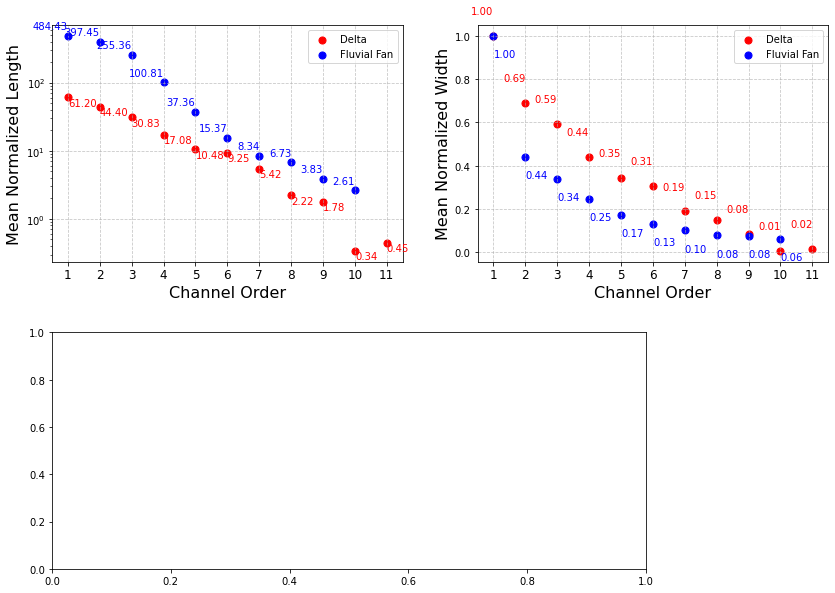

In [52]:
# Recompute delta_order_means and fan_order_means to include Mean Length and Mean Width
delta_order_means = LWData.groupby('ChannelOrder').agg({
    'NormChannelLength': 'mean',
    'NormChannelWidth': 'mean'
}).reset_index()
delta_order_means.columns = ['ChannelOrder', 'Mean Length', 'Mean Width']

fan_order_means = LWDataFan.groupby('ChannelOrder').agg({
    'NormChannelLength': 'mean',
    'NormChannelWidth': 'mean'
}).reset_index()
fan_order_means.columns = ['ChannelOrder', 'Mean Length', 'Mean Width']

# Ensure numeric type for sorting (order-based plots)
delta_order_means['ChannelOrder'] = pd.to_numeric(delta_order_means['ChannelOrder'], errors='coerce')
fan_order_means['ChannelOrder'] = pd.to_numeric(fan_order_means['ChannelOrder'], errors='coerce')

# Combine all unique orders and sort them
all_orders = sorted(set(delta_order_means['ChannelOrder'].dropna()).union(set(fan_order_means['ChannelOrder'].dropna())))

# Compute overall means for deltas and fluvial fans
delta_overall_length = LWData['NormChannelLength'].mean()
delta_overall_width = LWData['NormChannelWidth'].mean()
fan_overall_length = LWDataFan['NormChannelLength'].mean()
fan_overall_width = LWDataFan['NormChannelWidth'].mean()

# Define colors for delta types
delta_colors = {
    'River-dominated': 'red',
    'Wave-influenced': 'orange',
    'Tide-influenced': '#DAA520'  # Darker gold instead of yellow
}

# Define colors for fluvial fan termination styles
fan_colors = {
    'Axial': '#1f77b4',
    'Contributory': '#ff7f0e',
    'Dunes/Desert': '#2ca02c',
    'Playa': '#d62728',
    'Lake': '#9467bd',
    'Marine': '#8c564b',
    'Wetlands': '#e377c2'
}

# Set up the figure with custom gridspec
fig = plt.figure(figsize=(15, 10))
gs = fig.add_gridspec(2, 14, height_ratios=[1, 1], hspace=0.3, wspace=0.3)

# Assign subplots: top row (Lengths, Widths each 7 units), bottom row (merged plot 10 units)
ax0 = fig.add_subplot(gs[0, 0:6])
ax1 = fig.add_subplot(gs[0, 7:13])
ax2 = fig.add_subplot(gs[1, 0:10])  # Merged bottom plot (10 units wide)

# --- Top Left: Normalized Length by Channel Order ---
ax0.scatter(delta_order_means['ChannelOrder'], delta_order_means['Mean Length'], 
            color='red', label='Delta', marker='o', s=50)
ax0.scatter(fan_order_means['ChannelOrder'], fan_order_means['Mean Length'], 
            color='blue', label='Fluvial Fan', marker='o', s=50)
ax0.set_ylabel('Mean Normalized Length', fontsize=16)
ax0.set_xlabel('Channel Order', fontsize=16)
ax0.legend(fontsize=10)
ax0.set_yscale('log')  # Log scale for length
ax0.grid(True, linestyle='--', alpha=0.7)
ax0.set_xticks(all_orders)
ax0.set_xticklabels([str(int(o)) for o in all_orders], fontsize=12)

# Annotate length values
for _, row in delta_order_means.iterrows():
    ax0.text(row['ChannelOrder'], row['Mean Length'] * .75, f"{row['Mean Length']:.2f}",
             color='red', ha='left', fontsize=10)
for _, row in fan_order_means.iterrows():
    ax0.text(row['ChannelOrder'], row['Mean Length'] * 1.25, f"{row['Mean Length']:.2f}",
             color='blue', ha='right', fontsize=10)

# --- Top Right: Normalized Width by Channel Order ---
ax1.scatter(delta_order_means['ChannelOrder'], delta_order_means['Mean Width'], 
            color='red', label='Delta', marker='o', s=50)
ax1.scatter(fan_order_means['ChannelOrder'], fan_order_means['Mean Width'], 
            color='blue', label='Fluvial Fan', marker='o', s=50)
ax1.set_ylabel('Mean Normalized Width', fontsize=16)
ax1.set_xlabel('Channel Order', fontsize=16)
ax1.legend(fontsize=10)
ax1.grid(True, linestyle='--', alpha=0.7)
ax1.set_xticks(all_orders)
ax1.set_xticklabels([str(int(o)) for o in all_orders], fontsize=12)

# Annotate width values
for _, row in delta_order_means.iterrows():
    ax1.text(row['ChannelOrder'], row['Mean Width'] + 0.1, f"{row['Mean Width']:.2f}",
             color='red', ha='right', fontsize=10)
for _, row in fan_order_means.iterrows():
    ax1.text(row['ChannelOrder'], row['Mean Width'] - 0.1, f"{row['Mean Width']:.2f}",
             color='blue', ha='left', fontsize=10)

# --- Bottom: Merged Delta Types and Fluvial Fan Termination Styles ---
delta_types = delta_type_means['Type']
fan_styles = fan_type_means['Type']
all_types = list(delta_types) + [''] + list(fan_styles)  # Add space between delta and fan types
x_positions = np.arange(len(all_types))

# Plot delta types
for i, row in delta_type_means.iterrows():
    type_name = row['Type']
    color = delta_colors.get(type_name, 'black')
    ax2.scatter([i], [row['Mean Length']], color=color, label=f'{type_name} Length', marker='o', s=50)
    ax2.scatter([i], [row['Mean Width']], color=color, label=f'{type_name} Width', marker='s', s=50)

# Plot fluvial fan styles (offset by delta types length + 1 for gap)
offset = len(delta_types) + 1
for i, row in fan_type_means.iterrows():
    style_name = row['Type']
    color = fan_colors.get(style_name, 'black')
    ax2.scatter([i + offset], [row['Mean Length']], color=color, label=f'{style_name} Length', marker='o', s=50)
    ax2.scatter([i + offset], [row['Mean Width']], color=color, label=f'{style_name} Width', marker='s', s=50)

# Plot overall mean lines
ax2.axhline(delta_overall_length, color='red', linestyle='--', label='Delta Length Average', linewidth=2)
ax2.axhline(delta_overall_width, color='red', linestyle=':', label='Delta Width Average', linewidth=2)
ax2.axhline(fan_overall_length, color='blue', linestyle='--', label='Fluvial Fan Length Average', linewidth=2)
ax2.axhline(fan_overall_width, color='blue', linestyle=':', label='Fluvial Fan Width Average', linewidth=2)

ax2.set_xlabel('Delta Type / Fluvial Fan Termination Style', fontsize=18)
ax2.set_ylabel('Mean Value', fontsize=16)
ax2.set_yscale('log')  # Log scale for length/width
ax2.grid(True, linestyle='--', alpha=0.7)

# Adjust x-limits to fit content snugly
ax2.set_xlim(-0.5, len(all_types) - 0.5)

# Annotate delta type values
for i, row in delta_type_means.iterrows():
    type_name = row['Type']
    color = delta_colors.get(type_name, 'black')
    ax2.text(i - 0.1, row['Mean Length'] * 1.1, f"{row['Mean Length']:.2f}",
             color=color, ha='right', fontsize=10)
    ax2.text(i + 0.1, row['Mean Width'] * 1.1, f"{row['Mean Width']:.2f}",
             color=color, ha='left', fontsize=10)

# Annotate fan style values
for i, row in fan_type_means.iterrows():
    style_name = row['Type']
    color = fan_colors.get(style_name, 'black')
    ax2.text(i + offset - 0.1, row['Mean Length'] * 1.1, f"{row['Mean Length']:.2f}",
             color=color, ha='right', fontsize=10)
    ax2.text(i + offset + 0.1, row['Mean Width'] * 1.1, f"{row['Mean Width']:.2f}",
             color=color, ha='left', fontsize=10)

# Annotate overall mean lines
ax2.text(0, delta_overall_length * 1.05, f"{delta_overall_length:.2f}",
         color='red', ha='left', va='bottom', fontsize=10)
ax2.text(0, delta_overall_width * 0.95, f"{delta_overall_width:.2f}",
         color='red', ha='left', va='top', fontsize=10)
ax2.text(offset, fan_overall_length * 1.05, f"{fan_overall_length:.2f}",
         color='blue', ha='left', va='bottom', fontsize=10)
ax2.text(offset, fan_overall_width * 0.95, f"{fan_overall_width:.2f}",
         color='blue', ha='left', va='top', fontsize=10)

# Set x-ticks for all types
ax2.set_xticks(x_positions)
ax2.set_xticklabels(all_types, rotation=30, ha='right', fontsize=16)

# Place legend on the right, fitting in the remaining 4 units
ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10, ncol=1)

plt.tight_layout()
plt.show()

C:\Users\lukej\AppData\Local\Temp\ipykernel_38552\3721049607.py:146: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


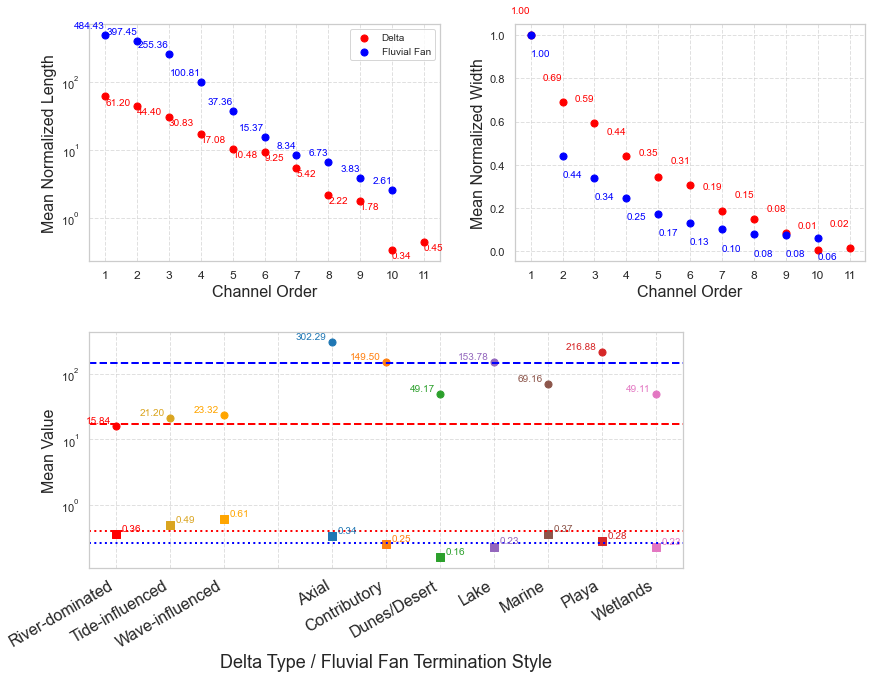

In [60]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# --- Compute Means by Channel Order ---
delta_order_means = LWData.groupby('ChannelOrder').agg({
    'NormChannelLength': 'mean',
    'NormChannelWidth': 'mean'
}).reset_index()
delta_order_means.columns = ['ChannelOrder', 'Mean Length', 'Mean Width']

fan_order_means = LWDataFan.groupby('ChannelOrder').agg({
    'NormChannelLength': 'mean',
    'NormChannelWidth': 'mean'
}).reset_index()
fan_order_means.columns = ['ChannelOrder', 'Mean Length', 'Mean Width']

# Ensure numeric type for sorting
delta_order_means['ChannelOrder'] = pd.to_numeric(delta_order_means['ChannelOrder'], errors='coerce')
fan_order_means['ChannelOrder'] = pd.to_numeric(fan_order_means['ChannelOrder'], errors='coerce')

# Combine all unique orders and sort
all_orders = sorted(set(delta_order_means['ChannelOrder'].dropna()).union(set(fan_order_means['ChannelOrder'].dropna())))

# Overall means
delta_overall_length = LWData['NormChannelLength'].mean()
delta_overall_width = LWData['NormChannelWidth'].mean()
fan_overall_length = LWDataFan['NormChannelLength'].mean()
fan_overall_width = LWDataFan['NormChannelWidth'].mean()

# --- Compute Means by Type/Termination Style ---
# Make sure the columns exist in your data
delta_type_means = LWData.groupby('Type').agg({
    'NormChannelLength': 'mean',
    'NormChannelWidth': 'mean'
}).reset_index()
delta_type_means.columns = ['Type', 'Mean Length', 'Mean Width']

fan_type_means = LWDataFan.groupby('Type').agg({
    'NormChannelLength': 'mean',
    'NormChannelWidth': 'mean'
}).reset_index()
fan_type_means.columns = ['Type', 'Mean Length', 'Mean Width']

# --- Define Colors ---
delta_colors = {
    'River-dominated': 'red',
    'Wave-influenced': 'orange',
    'Tide-influenced': '#DAA520'
}

fan_colors = {
    'Axial': '#1f77b4',
    'Contributory': '#ff7f0e',
    'Dunes/Desert': '#2ca02c',
    'Playa': '#d62728',
    'Lake': '#9467bd',
    'Marine': '#8c564b',
    'Wetlands': '#e377c2'
}

# --- Set up figure and gridspec ---
fig = plt.figure(figsize=(15, 10))
gs = fig.add_gridspec(2, 14, height_ratios=[1, 1], hspace=0.3, wspace=0.3)

ax0 = fig.add_subplot(gs[0, 0:6])
ax1 = fig.add_subplot(gs[0, 7:13])
ax2 = fig.add_subplot(gs[1, 0:10])

# --- Top Left: Mean Length by Channel Order ---
ax0.scatter(delta_order_means['ChannelOrder'], delta_order_means['Mean Length'], color='red', label='Delta', s=50)
ax0.scatter(fan_order_means['ChannelOrder'], fan_order_means['Mean Length'], color='blue', label='Fluvial Fan', s=50)
ax0.set_xlabel('Channel Order', fontsize=16)
ax0.set_ylabel('Mean Normalized Length', fontsize=16)
ax0.set_yscale('log')
ax0.grid(True, linestyle='--', alpha=0.7)
ax0.set_xticks(all_orders)
ax0.set_xticklabels([str(int(o)) for o in all_orders], fontsize=12)
ax0.legend(fontsize=10)

# Annotate length values
for _, row in delta_order_means.iterrows():
    ax0.text(row['ChannelOrder'], row['Mean Length'] * 0.75, f"{row['Mean Length']:.2f}", color='red', ha='left', fontsize=10)
for _, row in fan_order_means.iterrows():
    ax0.text(row['ChannelOrder'], row['Mean Length'] * 1.25, f"{row['Mean Length']:.2f}", color='blue', ha='right', fontsize=10)

# --- Top Right: Mean Width by Channel Order ---
ax1.scatter(delta_order_means['ChannelOrder'], delta_order_means['Mean Width'], color='red', s=50)
ax1.scatter(fan_order_means['ChannelOrder'], fan_order_means['Mean Width'], color='blue', s=50)
ax1.set_xlabel('Channel Order', fontsize=16)
ax1.set_ylabel('Mean Normalized Width', fontsize=16)
ax1.grid(True, linestyle='--', alpha=0.7)
ax1.set_xticks(all_orders)
ax1.set_xticklabels([str(int(o)) for o in all_orders], fontsize=12)

# Annotate width values
for _, row in delta_order_means.iterrows():
    ax1.text(row['ChannelOrder'], row['Mean Width'] + 0.1, f"{row['Mean Width']:.2f}", color='red', ha='right', fontsize=10)
for _, row in fan_order_means.iterrows():
    ax1.text(row['ChannelOrder'], row['Mean Width'] - 0.1, f"{row['Mean Width']:.2f}", color='blue', ha='left', fontsize=10)

# --- Bottom: Mean by Delta Type / Fan Termination Style ---
delta_types = delta_type_means['Type']
fan_styles = fan_type_means['Type']
all_types = list(delta_types) + [''] + list(fan_styles)
x_positions = np.arange(len(all_types))

# Plot delta types
for i, row in delta_type_means.iterrows():
    color = delta_colors.get(row['Type'], 'black')
    ax2.scatter([i], [row['Mean Length']], color=color, marker='o', s=50)
    ax2.scatter([i], [row['Mean Width']], color=color, marker='s', s=50)

# Plot fan styles (offset by delta types + 1)
offset = len(delta_types) + 1
for i, row in fan_type_means.iterrows():
    color = fan_colors.get(row['Type'], 'black')
    ax2.scatter([i + offset], [row['Mean Length']], color=color, marker='o', s=50)
    ax2.scatter([i + offset], [row['Mean Width']], color=color, marker='s', s=50)

# Overall mean lines
ax2.axhline(delta_overall_length, color='red', linestyle='--', linewidth=2)
ax2.axhline(delta_overall_width, color='red', linestyle=':', linewidth=2)
ax2.axhline(fan_overall_length, color='blue', linestyle='--', linewidth=2)
ax2.axhline(fan_overall_width, color='blue', linestyle=':', linewidth=2)

ax2.set_xlabel('Delta Type / Fluvial Fan Termination Style', fontsize=18)
ax2.set_ylabel('Mean Value', fontsize=16)
ax2.set_yscale('log')
ax2.grid(True, linestyle='--', alpha=0.7)
ax2.set_xlim(-0.5, len(all_types)-0.5)
ax2.set_xticks(x_positions)
ax2.set_xticklabels(all_types, rotation=30, ha='right', fontsize=16)

# Annotate delta and fan values
for i, row in delta_type_means.iterrows():
    color = delta_colors.get(row['Type'], 'black')
    ax2.text(i - 0.1, row['Mean Length'] * 1.1, f"{row['Mean Length']:.2f}", color=color, ha='right', fontsize=10)
    ax2.text(i + 0.1, row['Mean Width'] * 1.1, f"{row['Mean Width']:.2f}", color=color, ha='left', fontsize=10)
for i, row in fan_type_means.iterrows():
    color = fan_colors.get(row['Type'], 'black')
    ax2.text(i + offset - 0.1, row['Mean Length'] * 1.1, f"{row['Mean Length']:.2f}", color=color, ha='right', fontsize=10)
    ax2.text(i + offset + 0.1, row['Mean Width'] * 1.1, f"{row['Mean Width']:.2f}", color=color, ha='left', fontsize=10)

plt.tight_layout()
plt.show()

C:\Users\lukej\AppData\Local\Temp\ipykernel_38552\1517530328.py:161: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


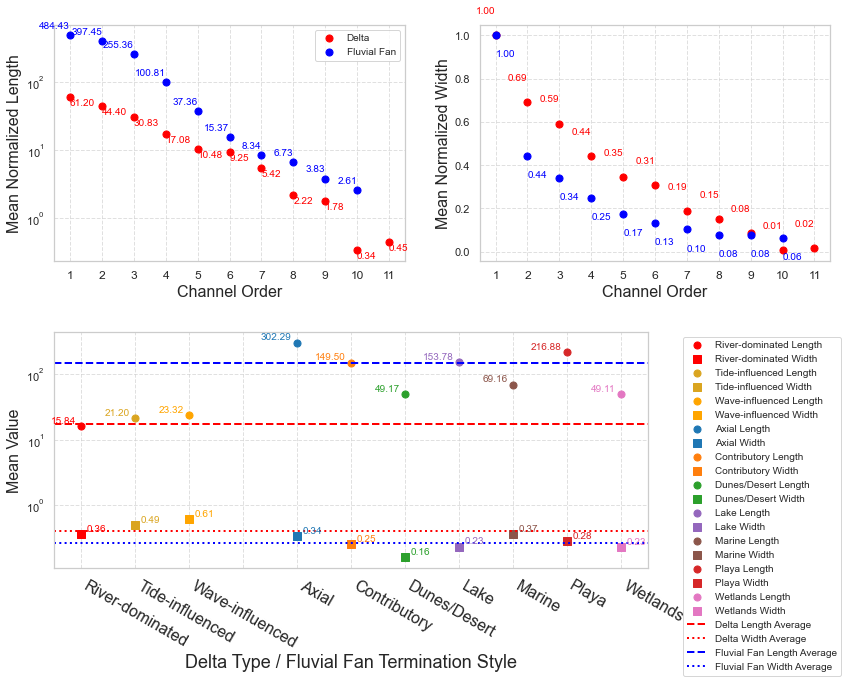

In [68]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# --- Compute Means by Channel Order ---
delta_order_means = LWData.groupby('ChannelOrder').agg({
    'NormChannelLength': 'mean',
    'NormChannelWidth': 'mean'
}).reset_index()
delta_order_means.columns = ['ChannelOrder', 'Mean Length', 'Mean Width']

fan_order_means = LWDataFan.groupby('ChannelOrder').agg({
    'NormChannelLength': 'mean',
    'NormChannelWidth': 'mean'
}).reset_index()
fan_order_means.columns = ['ChannelOrder', 'Mean Length', 'Mean Width']

# Ensure numeric type for sorting
delta_order_means['ChannelOrder'] = pd.to_numeric(delta_order_means['ChannelOrder'], errors='coerce')
fan_order_means['ChannelOrder'] = pd.to_numeric(fan_order_means['ChannelOrder'], errors='coerce')

# Combine all unique orders and sort
all_orders = sorted(set(delta_order_means['ChannelOrder'].dropna()).union(set(fan_order_means['ChannelOrder'].dropna())))

# Overall means
delta_overall_length = LWData['NormChannelLength'].mean()
delta_overall_width = LWData['NormChannelWidth'].mean()
fan_overall_length = LWDataFan['NormChannelLength'].mean()
fan_overall_width = LWDataFan['NormChannelWidth'].mean()

# --- Compute Means by Type/Termination Style ---
# Make sure your DataFrames have a 'Type' column
delta_type_means = LWData.groupby('Type').agg({
    'NormChannelLength': 'mean',
    'NormChannelWidth': 'mean'
}).reset_index()
delta_type_means.columns = ['Type', 'Mean Length', 'Mean Width']

fan_type_means = LWDataFan.groupby('Type').agg({
    'NormChannelLength': 'mean',
    'NormChannelWidth': 'mean'
}).reset_index()
fan_type_means.columns = ['Type', 'Mean Length', 'Mean Width']

# --- Define Colors ---
delta_colors = {
    'River-dominated': 'red',
    'Wave-influenced': 'orange',
    'Tide-influenced': '#DAA520'
}

fan_colors = {
    'Axial': '#1f77b4',
    'Contributory': '#ff7f0e',
    'Dunes/Desert': '#2ca02c',
    'Playa': '#d62728',
    'Lake': '#9467bd',
    'Marine': '#8c564b',
    'Wetlands': '#e377c2'
}

# --- Set up figure and gridspec ---
fig = plt.figure(figsize=(15, 10))
gs = fig.add_gridspec(2, 14, height_ratios=[1, 1], hspace=0.3, wspace=0.3)

ax0 = fig.add_subplot(gs[0, 0:6])
ax1 = fig.add_subplot(gs[0, 7:13])
ax2 = fig.add_subplot(gs[1, 0:10])

# --- Top Left: Mean Length by Channel Order ---
ax0.scatter(delta_order_means['ChannelOrder'], delta_order_means['Mean Length'], color='red', label='Delta', s=50)
ax0.scatter(fan_order_means['ChannelOrder'], fan_order_means['Mean Length'], color='blue', label='Fluvial Fan', s=50)
ax0.set_xlabel('Channel Order', fontsize=16)
ax0.set_ylabel('Mean Normalized Length', fontsize=16)
ax0.set_yscale('log')
ax0.grid(True, linestyle='--', alpha=0.7)
ax0.set_xticks(all_orders)
ax0.set_xticklabels([str(int(o)) for o in all_orders], fontsize=12)
ax0.legend(fontsize=10)

# Annotate length values
for _, row in delta_order_means.iterrows():
    ax0.text(row['ChannelOrder'], row['Mean Length'] * 0.75, f"{row['Mean Length']:.2f}", color='red', ha='left', fontsize=10)
for _, row in fan_order_means.iterrows():
    ax0.text(row['ChannelOrder'], row['Mean Length'] * 1.25, f"{row['Mean Length']:.2f}", color='blue', ha='right', fontsize=10)

# --- Top Right: Mean Width by Channel Order ---
ax1.scatter(delta_order_means['ChannelOrder'], delta_order_means['Mean Width'], color='red', s=50)
ax1.scatter(fan_order_means['ChannelOrder'], fan_order_means['Mean Width'], color='blue', s=50)
ax1.set_xlabel('Channel Order', fontsize=16)
ax1.set_ylabel('Mean Normalized Width', fontsize=16)
ax1.grid(True, linestyle='--', alpha=0.7)
ax1.set_xticks(all_orders)
ax1.set_xticklabels([str(int(o)) for o in all_orders], fontsize=12)

# Annotate width values
for _, row in delta_order_means.iterrows():
    ax1.text(row['ChannelOrder'], row['Mean Width'] + 0.1, f"{row['Mean Width']:.2f}", color='red', ha='right', fontsize=10)
for _, row in fan_order_means.iterrows():
    ax1.text(row['ChannelOrder'], row['Mean Width'] - 0.1, f"{row['Mean Width']:.2f}", color='blue', ha='left', fontsize=10)

# --- Bottom: Mean by Delta Type / Fan Termination Style ---
delta_types = delta_type_means['Type']
fan_styles = fan_type_means['Type']
all_types = list(delta_types) + [''] + list(fan_styles)
x_positions = np.arange(len(all_types))

added_labels = set()

# Plot delta types
for i, row in delta_type_means.iterrows():
    color = delta_colors.get(row['Type'], 'black')
    label_len = f"{row['Type']} Length" if row['Type'] not in added_labels else None
    label_wid = f"{row['Type']} Width" if row['Type'] not in added_labels else None
    ax2.scatter([i], [row['Mean Length']], color=color, marker='o', s=50, label=label_len)
    ax2.scatter([i], [row['Mean Width']], color=color, marker='s', s=50, label=label_wid)
    added_labels.add(row['Type'])

# Plot fan styles (offset)
offset = len(delta_types) + 1
for i, row in fan_type_means.iterrows():
    color = fan_colors.get(row['Type'], 'black')
    label_len = f"{row['Type']} Length" if row['Type'] not in added_labels else None
    label_wid = f"{row['Type']} Width" if row['Type'] not in added_labels else None
    ax2.scatter([i + offset], [row['Mean Length']], color=color, marker='o', s=50, label=label_len)
    ax2.scatter([i + offset], [row['Mean Width']], color=color, marker='s', s=50, label=label_wid)
    added_labels.add(row['Type'])

# Overall mean lines
line_labels = [
    ('Delta Length Average', delta_overall_length, 'red', '--'),
    ('Delta Width Average', delta_overall_width, 'red', ':'),
    ('Fluvial Fan Length Average', fan_overall_length, 'blue', '--'),
    ('Fluvial Fan Width Average', fan_overall_width, 'blue', ':')
]
for lbl, val, color, style in line_labels:
    ax2.axhline(val, color=color, linestyle=style, linewidth=2, label=lbl)

ax2.set_xlabel('Delta Type / Fluvial Fan Termination Style', fontsize=18)
ax2.set_ylabel('Mean Value', fontsize=16)
ax2.set_yscale('log')
ax2.grid(True, linestyle='--', alpha=0.7)
ax2.set_xlim(-0.5, len(all_types)-0.5)
ax2.set_xticks(x_positions)
ax2.set_xticklabels(all_types, rotation=330, ha='left', fontsize=16)

# Annotate delta and fan values
for i, row in delta_type_means.iterrows():
    color = delta_colors.get(row['Type'], 'black')
    ax2.text(i - 0.1, row['Mean Length'] * 1.1, f"{row['Mean Length']:.2f}", color=color, ha='right', fontsize=10)
    ax2.text(i + 0.1, row['Mean Width'] * 1.1, f"{row['Mean Width']:.2f}", color=color, ha='left', fontsize=10)
for i, row in fan_type_means.iterrows():
    color = fan_colors.get(row['Type'], 'black')
    ax2.text(i + offset - 0.1, row['Mean Length'] * 1.1, f"{row['Mean Length']:.2f}", color=color, ha='right', fontsize=10)
    ax2.text(i + offset + 0.1, row['Mean Width'] * 1.1, f"{row['Mean Width']:.2f}", color=color, ha='left', fontsize=10)

# --- Legend for bottom subplot ---
ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10, ncol=1)

plt.tight_layout()
plt.show()


In [ ]:
# Ensure ChannelOrder is numeric
LWDataFan['ChannelOrder'] = pd.to_numeric(LWDataFan['ChannelOrder'], errors='coerce')

# Filter for 1st order fluvial fan channels
first_order_fans = LWDataFan[LWDataFan['ChannelOrder'] == 1][['NormChannelLength', 'NormChannelWidth']]

# Display the results
print("1st Order Fluvial Fan Channel Measurements:")
print(first_order_fans)

In [ ]:
# Load your data
df = pd.read_csv('landforms.csv')  # Must have 'Name' and 'Slope'
# ADataFan should already be loaded with 'Name' and 'Angle'

# Step 1: Average angle for each fan
avg_angles = ADataFan.groupby('Name')['Angle'].mean().reset_index()
avg_angles.rename(columns={'Angle': 'Avg_Angle'}, inplace=True)

# Step 2: Merge with slopes
merged_df = pd.merge(avg_angles, df[['Name', 'Slope']], on='Name', how='inner')

# Step 3: Create scatter plot with flipped axes
plt.figure(figsize=(7, 5))
plt.scatter(merged_df['Avg_Angle'], merged_df['Slope'], color='green', alpha=0.75)

# Labels and formatting
plt.title('Slope vs. Average Fan Angle', fontsize=16)
plt.xlabel('Average Angle (°)', fontsize=14)
plt.ylabel('Slope (°)', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Optional: Add labels for each point
for i, row in merged_df.iterrows():
    plt.text(row['Avg_Angle'], row['Slope'], row['Name'], fontsize=10, alpha=0.7)

plt.grid(True)
plt.tight_layout()
plt.show()


In [53]:
import pandas as pd

# Calculate mean and median for each delta
delta_stats = AData.groupby('Name')['Angle'].agg(
    MeanAngle='mean', 
    MedianAngle='median'
).reset_index()

# Calculate mean and median for each fluvial fan
fan_stats = ADataFan.groupby('Name')['Angle'].agg(
    MeanAngle='mean', 
    MedianAngle='median'
).reset_index()

# Print the results with tabs between the columns for easier Excel parsing
print("Delta Bifurcation Angles (copy into Excel):")
print("Name\tMeanAngle\tMedianAngle")
for _, row in delta_stats.iterrows():
    print(f"{row['Name']}\t{row['MeanAngle']:.2f}\t{row['MedianAngle']:.2f}")

print("\nFluvial Fan Divergence Angles (copy into Excel):")
print("Name\tMeanAngle\tMedianAngle")
for _, row in fan_stats.iterrows():
    print(f"{row['Name']}\t{row['MeanAngle']:.2f}\t{row['MedianAngle']:.2f}")



Delta Bifurcation Angles (copy into Excel):
Name	MeanAngle	MedianAngle
Apalachicola	70.21	64.50
Atchafalaya	65.87	67.00
Athabasca	70.56	71.00
Atrato	74.64	73.00
Ayeyarwady	81.86	72.00
Burdekin	71.20	71.00
Colville	74.00	74.50
Danube	84.50	79.00
Dniper	74.67	72.50
Don	83.07	83.00
Dvina	71.70	70.50
Khovd	74.67	72.00
Kobuk	75.09	70.50
Krishna	67.67	69.00
Lena	82.62	80.00
Mackenzie	74.67	76.00
Mahakam	70.47	72.00
Mamawi	70.91	71.00
Mekong	63.33	59.50
Mississippi	72.44	68.00
Niger	77.67	78.00
Orinoco	72.35	71.00
Parana	75.82	77.00
Po	62.43	56.00
Poyang	65.58	67.00
Protoka Ularovskaya	76.13	73.00
Pur	61.50	61.50
Purari	78.00	80.00
Rajang	71.80	71.00
Red	69.62	64.00
Rioni	67.00	67.00
Rufiji	76.60	84.00
Saskatchewan	71.81	71.00
Selenga	79.19	74.00
Sinu	82.50	82.50
Slave	97.00	94.50
Volga	79.73	71.94
Wax Lake	64.73	60.00
Yukon	82.46	77.50
Zambezi	59.33	52.00

Fluvial Fan Divergence Angles (copy into Excel):
Name	MeanAngle	MedianAngle
Abrisham	55.63	53.00
Aichilik	60.83	56.50
Aksu	67.92	66.00
Bu

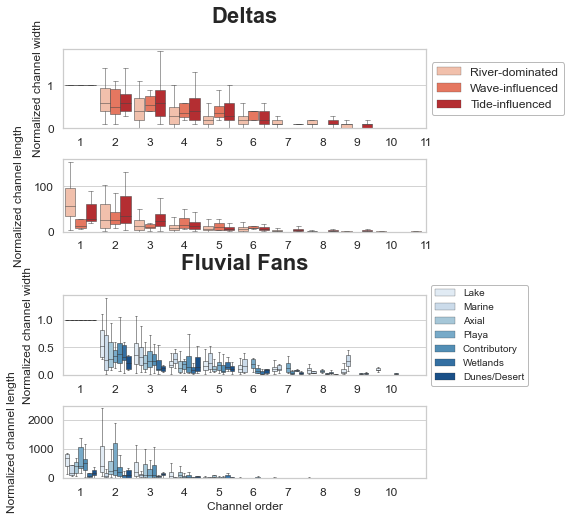

In [54]:
# Set white background with light grey grid lines
sns.set_theme(style="whitegrid", rc={"axes.facecolor": "white", "grid.color": "lightgrey"})

# Create subplots with grid layout
fig = plt.figure(figsize=(6.5, 8.5))  # Extra space for subheadings
gs = gridspec.GridSpec(6, 1, height_ratios=[0.05, 2.2, 2, 0.05, 2.2, 2])  # Include space for subheadings

# Subheading for Deltas
ax_subtitle1 = plt.subplot(gs[0])
ax_subtitle1.text(0.5, 0.5, "Deltas", ha="center", va="center", fontsize=22, fontweight='bold')
ax_subtitle1.axis("off")

# Plot a
ax0 = plt.subplot(gs[1])
sns.boxplot(
    y=LWData.NormChannelWidth,
    x=LWData.ChannelOrder,
    data=LWData,
    palette="Reds",
    hue='Type',
    width=.9,
    linewidth=.5,
    fliersize=0,
    ax=ax0
)
ax0.set_xlabel('')
ax0.set_ylabel('Normalized channel width', fontsize=12)
ax0.tick_params(axis='both', labelsize=12)
ax0.set_ylim(0, 1.85)
ax0.set_xlim(-0.5, 10)
ax0.set_xticklabels([str(int(float(label.get_text()))) for label in ax0.get_xticklabels()])

legend0 = ax0.legend(fontsize=12, bbox_to_anchor=(1, 0.5), loc='center left')
legend0.get_frame().set_facecolor('white')
legend0.get_frame().set_edgecolor('darkgrey')
for artist in ax0.artists:
    artist.set_edgecolor('black')

# Plot b
ax1 = plt.subplot(gs[2])
sns.boxplot(
    y=LWData.NormChannelLength,
    x=LWData.ChannelOrder,
    data=LWData,
    palette="Reds",
    hue='Type',
    width=.9,
    linewidth=.5,
    fliersize=0,
    ax=ax1
)
ax1.set_xlabel('')
ax1.set_ylabel('Normalized channel length', fontsize=12, labelpad=10)
ax1.tick_params(axis='both', labelsize=12)
ax1.set_xlim(-0.5, 10)
ax1.set_ylim(0, 160)
ax1.set_xticklabels([str(int(float(label.get_text()))) for label in ax1.get_xticklabels()])
ax1.legend().set_visible(False)
for artist in ax1.artists:
    artist.set_edgecolor('black')

# Subheading for Fluvial Fans
ax_subtitle2 = plt.subplot(gs[3])
ax_subtitle2.text(0.5, 0.4, "Fluvial Fans", ha="center", va="center", fontsize=22, fontweight='bold')
ax_subtitle2.axis("off")

# Plot c
ax2 = plt.subplot(gs[4])
sns.boxplot(
    y=LWDataFan.NormChannelWidth,
    x=LWDataFan.ChannelOrder,
    data=LWDataFan,
    width=.9,
    linewidth=.5,
    palette="Blues",
    hue='Type',
    fliersize=0,
    ax=ax2
)
ax2.set_xlabel('')
ax2.set_ylabel('Normalized channel width', fontsize=12)
ax2.set_xlim(-0.5, 10)
ax2.set_ylim(0, 1.45)
ax2.tick_params(axis='both', labelsize=12)

legend2 = ax2.legend(fontsize=10, bbox_to_anchor=(1, 0.5), loc='center left')
legend2.get_frame().set_facecolor('white')
legend2.get_frame().set_edgecolor('darkgrey')
for artist in ax2.artists:
    artist.set_edgecolor('black')

# Plot d
ax3 = plt.subplot(gs[5])
sns.boxplot(
    y=LWDataFan.NormChannelLength,
    x=LWDataFan.ChannelOrder,
    data=LWDataFan,
    width=.9,
    linewidth=.5,
    palette="Blues",
    hue='Type',
    fliersize=0,
    ax=ax3
)
ax3.set_xlabel('Channel order', fontsize=12)
ax3.set_ylabel('Normalized channel length', fontsize=12, labelpad=10)
ax3.set_xlim(-0.5, 10)
ax3.set_ylim(0, 2500)
ax3.set_yscale('linear')
ax3.tick_params(axis='both', labelsize=12)
ax3.legend().set_visible(False)
for artist in ax3.artists:
    artist.set_edgecolor('black')

# Adjust layout spacing
plt.subplots_adjust(hspace=0.6)

# Show plot
plt.show()

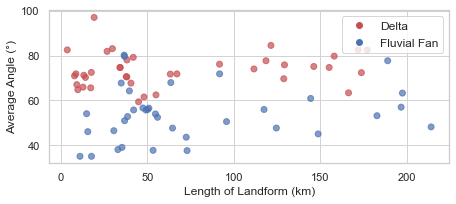

In [55]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

# Load landform metadata and angle data
df = pd.read_csv('Landforms.csv')
delta_angles = pd.read_csv('DeltaAngles.csv')
fan_angles = pd.read_csv('FluvialFanAngles.csv')

# Compute average angle per landform
delta_avg_angle = delta_angles.groupby('Name')['Angle'].mean().reset_index()
fan_avg_angle = fan_angles.groupby('Name')['Angle'].mean().reset_index()

# Merge with landform metadata
merged_avg = pd.merge(df, delta_avg_angle, how='left', on='Name')
merged_avg = pd.merge(merged_avg, fan_avg_angle, how='left', on='Name', suffixes=('_Delta', '_Fan'))

# Prioritize Delta angle, fallback to Fan if Delta is NaN
merged_avg['AvgAngle'] = merged_avg['Angle_Delta'].combine_first(merged_avg['Angle_Fan'])

# Assign colors by Type
merged_avg['color'] = merged_avg['Type'].map({'Delta': 'r', 'Fluvial Fan': 'b'})
merged_avg['color'].fillna('gray', inplace=True)

# Custom legend
legend_elements = [
    Line2D([0], [0], marker='o', color='w', label='Delta', markerfacecolor='r', markersize=8),
    Line2D([0], [0], marker='o', color='w', label='Fluvial Fan', markerfacecolor='b', markersize=8)
]

# Plot
plt.figure(figsize=(6.5, 3))
plt.scatter(merged_avg['Length'], merged_avg['AvgAngle'], c=merged_avg['color'], alpha=0.7)

plt.legend(handles=legend_elements, loc='upper right', fontsize=12)
plt.xlabel('Length of Landform (km)')
plt.ylabel('Average Angle (°)')
plt.grid(True)
plt.tight_layout()
plt.show()


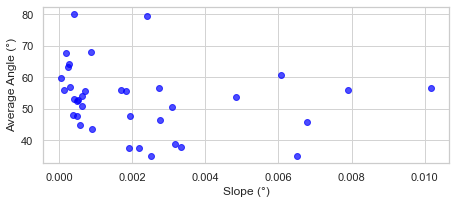

In [56]:
# Load your data
df = pd.read_csv('landforms.csv')  # Must have 'Name' and 'Slope'
# ADataFan should already be loaded with 'Name' and 'Angle'

# Step 1: Average angle for each fan
avg_angles = ADataFan.groupby('Name')['Angle'].mean().reset_index()
avg_angles.rename(columns={'Angle': 'Avg_Angle'}, inplace=True)

# Step 2: Merge with slopes
merged_df = pd.merge(avg_angles, df[['Name', 'Slope']], on='Name', how='inner')

# Step 3: Create scatter plot (styled to match, with flipped axes)
plt.figure(figsize=(6.5, 3))
plt.scatter(merged_df['Slope'], merged_df['Avg_Angle'], color='blue', alpha=0.7)

# Labels and formatting (flipped)
plt.xlabel('Slope (°)', fontsize=12)
plt.ylabel('Average Angle (°)', fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()


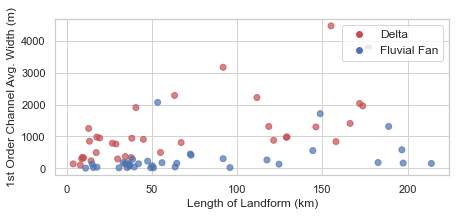

In [57]:
from matplotlib.lines import Line2D

# Load the dataframes
df = pd.read_csv('Landforms.csv')
LWData = pd.read_csv('DeltaLW.csv')
LWDataFan = pd.read_csv('FluvialFanLW.csv')

# Filter first-order channels
LWData_first_order = LWData[LWData['ChannelOrder'] == 1]
LWDataFan_first_order = LWDataFan[LWDataFan['ChannelOrder'] == 1]

# Calculate average ChannelWidthAvg for each landform (Name)
LWData_avg = LWData_first_order.groupby('Name')['ChannelWidthAvg'].mean().reset_index()
LWDataFan_avg = LWDataFan_first_order.groupby('Name')['ChannelWidthAvg'].mean().reset_index()

# Merge and prioritize Delta over Fan
merged_avg = pd.merge(df, LWData_avg, how='left', on='Name')
merged_avg = pd.merge(merged_avg, LWDataFan_avg, how='left', on='Name', suffixes=('_Delta', '_Fan'))
merged_avg['ChannelWidthAvg_Order1'] = merged_avg['ChannelWidthAvg_Delta'].combine_first(merged_avg['ChannelWidthAvg_Fan'])

# Assign colors
merged_avg['color'] = merged_avg['Type'].map({'Delta': 'r', 'Fluvial Fan': 'b'})
merged_avg['color'].fillna('gray', inplace=True)

# Plot
plt.figure(figsize=(6.5, 3))
plt.scatter(merged_avg['Length'], merged_avg['ChannelWidthAvg_Order1'], c=merged_avg['color'], alpha=0.7)

# Custom legend
legend_elements = [
    Line2D([0], [0], marker='o', color='w', label='Delta', markerfacecolor='r', markersize=8),
    Line2D([0], [0], marker='o', color='w', label='Fluvial Fan', markerfacecolor='b', markersize=8)
]
plt.legend(handles=legend_elements, loc='upper right', fontsize=12)

# Labels and grid
plt.xlabel('Length of Landform (km)')
plt.ylabel('1st Order Channel Avg. Width (m)')
plt.grid(True)

plt.tight_layout()
plt.show()


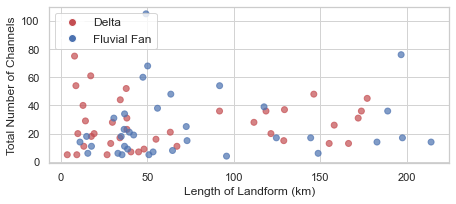

In [58]:
# Count number of channels per landform
delta_counts = LWData['Name'].value_counts().reset_index()
delta_counts.columns = ['Name', 'ChannelCount']

fan_counts = LWDataFan['Name'].value_counts().reset_index()
fan_counts.columns = ['Name', 'ChannelCount']

# Merge counts with df
merged_counts = pd.merge(df, delta_counts, how='left', on='Name')
merged_counts = pd.merge(merged_counts, fan_counts, how='left', on='Name', suffixes=('_Delta', '_Fan'))

# Combine counts (use Delta first, then Fan if missing)
merged_counts['ChannelCount'] = merged_counts['ChannelCount_Delta'].combine_first(merged_counts['ChannelCount_Fan'])

# Assign color by landform type
merged_counts['color'] = merged_counts['Type'].map({'Delta': 'r', 'Fluvial Fan': 'b'})
merged_counts['color'].fillna('gray', inplace=True)

# Plot: Channel Count vs. Landform Length
plt.figure(figsize=(6.5, 3))
plt.scatter(merged_counts['Length'], merged_counts['ChannelCount'], c=merged_counts['color'], alpha=0.7)

# Legend
legend_elements = [
    Line2D([0], [0], marker='o', color='w', label='Delta', markerfacecolor='r', markersize=8),
    Line2D([0], [0], marker='o', color='w', label='Fluvial Fan', markerfacecolor='b', markersize=8)
]
plt.legend(handles=legend_elements, loc='upper left', fontsize=12)

# Labels and layout
plt.xlabel('Length of Landform (km)')
plt.ylabel('Total Number of Channels')
plt.grid(True)
plt.tight_layout()
plt.show()

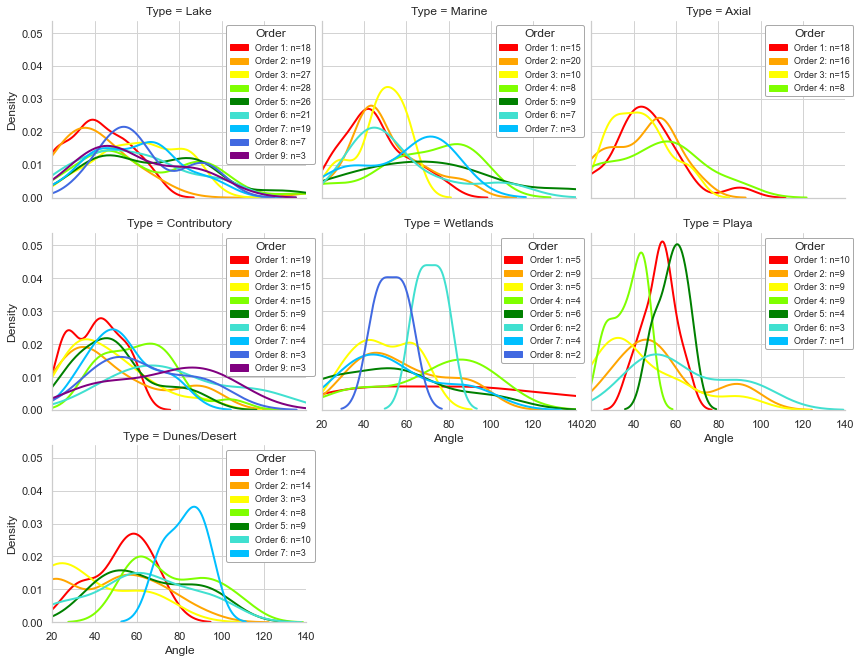

In [59]:
# Build order → color dictionary
order_palette = {i+1: c for i, c in enumerate(custom_palette)}

# Filter only valid orders
filtered = ADataFan[ADataFan['Order'].notna()].copy()
filtered['Order'] = filtered['Order'].astype(int)

# Create the FacetGrid
g = sns.FacetGrid(
    filtered,
    col="Type",
    hue="Order",
    col_wrap=3,
    height=4,
    sharex=True,
    sharey=True,
    palette=order_palette
)

# Plot KDEs with warn_singular=False
g.map(
    sns.kdeplot,
    "Angle",
    fill=False,
    common_norm=False,
    linewidth=2,
    bw_adjust=0.8,
    warn_singular=False
)

# Set consistent x-axis range for all subplots
g.set(xlim=(20, 140))

# Add legends to each subplot
for ax, term_style in zip(g.axes.flat, g.col_names):
    subset = filtered[filtered['Type'] == term_style]
    counts = subset['Order'].value_counts().sort_index()

    handles = [
        Patch(color=order_palette[o], label=f"Order {o}: n={counts.get(o, 0)}")
        for o in counts.index if o in order_palette
    ]

    ax.legend(
        handles=handles,
        title="Order",
        fontsize=9,
        frameon=True,
        framealpha=1,
        edgecolor='darkgrey',
        loc='upper right',
        bbox_to_anchor=(1.05, 1)
    )

# Final touches
g.fig.subplots_adjust(top=0.75)
g.fig.suptitle('', fontsize=16)
plt.show()

